In [1]:
import tifffile, os,sys,copy,time,cv2,math
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy import ndimage
import scipy.ndimage as ndi
from scipy.ndimage import zoom
from multiprocessing import Pool
from skimage import restoration
import cupy as cp
import cupyx.scipy.ndimage as cpx_ndimage
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SequentialFeatureSelector
import gc
import subprocess

# Lists for features
features = ['Hellinger Coefficient', 'Chernoff Coefficient', 'Jeffreys Distance', 
            'Directed Divergence', 'J-Divergence', 'L1', 'L2', 'Kullback-Leibler', 
            'Pearson', 'Jensen-Shannon','delta I','signal/noize']

features2 = ['Hellinger Coefficient', 'Chernoff Coefficient', 'Jeffreys Distance', 
            'Directed Divergence', 'J-Divergence', 'L1', 'L2', 'Kullback-Leibler', 
            'Pearson', 'Jensen-Shannon','ratio I','delta I','Tensor_xx', 'Tensor_yy', 'Tensor_zz']

all_features = [
    'Chernoff Coefficient', 'Kullback-Leibler', 'J-Divergence', 'delta I',
    'Jeffreys Distance', 'Jensen-Shannon', 'Directed Divergence', 'Pearson',
    'Hellinger Coefficient', 'L1', 'L2', 'signal/noize','Tensor_xx', 'Tensor_yy', 'Tensor_zz',"z","y","x"
]

psf_sigmas = [(3,3,3),(4,4,4),(4.5,4.5,4.5)]


def resize3D(img,original_size,after_size):
    ratio = original_size/after_size
    img = img.astype(np.float32)
    img_tmp = []
    for img0 in img:
        img1 = cv2.resize(img0, dsize=None, fx=ratio, fy=ratio)
        img_tmp.append(img1)
    img_tmp = np.array(img_tmp)
    img_tmp =img_tmp.T

    img_tmp2 = []
    for img0 in img_tmp:
        img1 = cv2.resize(img0, dsize=None, fx=ratio, fy=1)
        img_tmp2.append(img1)
    img_tmp2 = np.array(img_tmp2)
    return img_tmp2.T  
    
def Gaussian_filter_GPU(img_o, sigma):
    img = cp.asarray(img_o)
    dst=cpn.gaussian_filter(img,sigma=sigma, mode="reflect")
    dst2=cp.asnumpy(dst)
    del img
    del dst
    cp.get_default_memory_pool().free_all_blocks()
    return dst2

@jit(nopython=True)
def normalize_image(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)


def normalize(image):
    """画像を最小値と最大値で正規化する関数"""
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def min_max(x:np.ndarray):
    minval = x.min(axis=None, keepdims=True)
    maxval= x.max(axis=None, keepdims=True)
    result = (x-minval)/(maxval-minval)
    return result    
    
def makePSF(size, sigma_values):
    all_psfs = []
    for sigma in sigma_values:
        psflist = []
        target = np.zeros((size*2+1, size*2+1, size*2+1))
        target[target.shape[0]//2, target.shape[1]//2, target.shape[2]//2] = 1
        target = ndi.gaussian_filter(target, sigma=sigma)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                for k in range(-1, 2):
                    t = target.copy()
                    temp = np.roll(t, i, axis=0)
                    temp = np.roll(temp, j, axis=1)
                    temp = np.roll(temp, k, axis=2)
                    resized_temp = resize3D(temp, size, size*2+1)
                    psflist.append(resized_temp)
        
        psflist2 = [min_max(p) for p in psflist]
        all_psfs.extend(psflist2)
    
    psf_data = np.array(all_psfs)
    return psf_data
    
def LR_deconv(img,psf,i):
    im=img.copy()
    for n in range(i):
        print(n)
        normalize_and_convert_to_float(im)
        im1=im.copy()
        conv1=img/ndimage.convolve(im1, psf, mode='constant', cval=0.0)
        conv2=ndimage.convolve(conv1, psf, mode='constant', cval=0.0)
        im=im1*conv2 
    return im

def normalize_and_convert_to_float(array):
    float_array = array.astype(np.float32)
    min_val = float_array.min()
    max_val = float_array.max()
    normalized_array = (float_array - min_val) / (max_val - min_val)
    return normalized_array

   
def LR_deconv_GPU(img, psf, i, zval=40, overlap=10,zoom=(2.5, 2.5, 2.5)):
    psf=normalize_and_convert_to_float(psf)
    psf_cp =  cp.asarray(psf).astype(cp.float32)   
    im = img.astype(cp.float32)
    result = np.empty_like(im)
    for start_z in range(0, im.shape[0], zval - overlap):
        print("\tProcess deconvolution:"+str(start_z))
        end_z = min(start_z + zval, im.shape[0])
        im =im[start_z:end_z]
        im_gpu=cp.asarray(im).astype(cp.float32)
        im_gpu_d=im_gpu.copy()
        for n in range(i):
            conv1 = cp.divide(im_gpu_d, cpx_ndimage.convolve(im_gpu, psf_cp, mode='constant', cval=0.0))#
            conv2 = cpx_ndimage.convolve(conv1, psf_cp, mode='constant', cval=0.0)#
            if(n!=(i-1)):
                im_gpu *= conv2#u(t+1)
        if start_z==0:
            result[start_z:end_z] = cp.asnumpy(im_gpu)
        else:
            result[start_z+overlap//2:end_z] = cp.asnumpy(im_gpu[overlap//2:])
        cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_memory_pool().free_all_blocks()
    return result



def read_tiff_stack(folder_path, start_index=0, num_images=-1):
    # Get the list of TIFF files
    
    tiff_files = [os.path.join(folder_path, filename)
                  for filename in os.listdir(folder_path)
                  if filename.lower().endswith(('.tif', '.tiff'))]
    # Sort the files to ensure correct order
    tiff_files.sort()

    # Select the specified range of files
    if num_images == -1:
        tiff_files = tiff_files[start_index:]
    else:
        tiff_files = tiff_files[start_index:(start_index + num_images)]
    print("Load tiff:" + str(start_index) + "-" + str(len(tiff_files)))
    first_tiff = tifffile.imread(tiff_files[0])
    shape = (len(tiff_files),) + first_tiff.shape
    stack = np.empty(shape, dtype=np.uint16)

    # Read each TIFF file and store it in the stack
    for i, tiff_file in enumerate(tiff_files):
        stack[i] = tifffile.imread(tiff_file)

    return stack



class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [1] * n

    def find(self, u):
        if u != self.parent[u]:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v):
        root_u = self.find(u)
        root_v = self.find(v)
        
        if root_u != root_v:
            if self.rank[root_u] > self.rank[root_v]:
                self.parent[root_v] = root_u
            elif self.rank[root_u] < self.rank[root_v]:
                self.parent[root_u] = root_v
            else:
                self.parent[root_v] = root_u
                self.rank[root_u] += 1

def merge_lists(lists):
    # obtain maximum value
    max_value = max(max(lst) for lst in lists) + 1
    uf = UnionFind(max_value)
    
    # integrate elements in list
    for lst in lists:
        first = lst[0]
        for num in lst[1:]:
            uf.union(first, num)
    
    # find a group for elements
    groups = {}
    for lst in lists:
        root = uf.find(lst[0])
        if root not in groups:
            groups[root] = set()
        for num in lst:
            groups[root].add(num)
    
    return [sorted(list(group)) for group in groups.values()]



def makemask(size = 11):
    center = size // 2
    # マスクの初期化
    mask = np.zeros((size, size, size), dtype=int)
    # グリッドの各点について、マンハッタン距離を計算
    for x in range(size):
        for y in range(size):
            for z in range(size):
                if abs(x - center) + abs(y - center) + abs(z - center) <= 5:
                    mask[x, y, z] = 1
    return mask.astype(np.float64)

    

@jit(nopython=True)
def calculate_centroid_and_inertia_tensor_center_based(img):
    # 画像のノーマライズ
    norm_img = normalize_image(img)
    
    # 画像の形状
    shape = norm_img.shape
    
    # グリッド座標の計算
    z, y, x = np.indices(shape)
    
    # 総質量（輝度の総和）
    total_mass = np.sum(norm_img)
    
    # 重心の計算
    centroid_x = np.sum(x * norm_img) / total_mass
    centroid_y = np.sum(y * norm_img) / total_mass
    centroid_z = np.sum(z * norm_img) / total_mass
    centroid = np.array([centroid_x, centroid_y, centroid_z])
    
    # 画像の中心座標を計算
    center_x = shape[2] / 2
    center_y = shape[1] / 2
    center_z = shape[0] / 2
    center = np.array([center_x, center_y, center_z])
    
    # 中心を基準にしたグリッド座標の計算
    x_shifted = x - center_x
    y_shifted = y - center_y
    z_shifted = z - center_z
    
    # 慣性テンソルの計算
    Ixx = np.sum(norm_img * (y_shifted**2 + z_shifted**2))
    Iyy = np.sum(norm_img * (x_shifted**2 + z_shifted**2))
    Izz = np.sum(norm_img * (x_shifted**2 + y_shifted**2))
    Ixy = -np.sum(norm_img * x_shifted * y_shifted)
    Ixz = -np.sum(norm_img * x_shifted * z_shifted)
    Iyz = -np.sum(norm_img * y_shifted * z_shifted)
    
    inertia_tensor = np.array([[Ixx, Ixy, Ixz],
                               [Ixy, Iyy, Iyz],
                               [Ixz, Iyz, Izz]])
    
    # 偏芯（重心と中心の差）
    eccentricity = centroid - center
    
    return center, centroid, eccentricity, inertia_tensor


@jit(nopython=True)
def calculate_tensor_distance(tensor:np.ndarray):
    result=[]
    for i in range(len(tensor)):
        maxval = max(tensor[i][0, 0], tensor[i][1, 1], tensor[i][2, 2])
        result.append((maxval-tensor[i][0,0]+maxval-tensor[i][1,1]+maxval-tensor[i][2,2])/maxval)
    return result

def Get_tensor_features(ten):
    data=[]
    for t in ten:
        data.append([t[0,0],t[1,1],t[2,2]])
    return np.array(data)

def create_dataframe(d1p, d1n):
    # 'pos' グループ用の DataFrame の作成
    df_pos = pd.DataFrame({
        'Group': ['pos'] * len(d1p),
        'Hellinger Coefficient': [dp[0] for dp in d1p],
        'Chernoff Coefficient': [dp[1] for dp in d1p],
        'Jeffreys Distance': [dp[2] for dp in d1p],
        'Directed Divergence': [dp[3] for dp in d1p],
        'J-Divergence': [dp[4] for dp in d1p],
        'L1': [dp[5] for dp in d1p],
        'L2': [dp[6] for dp in d1p],
        'Kullback-Leibler': [dp[7] for dp in d1p],
        'Pearson': [dp[8] for dp in d1p],
        'Jensen-Shannon': [dp[9] for dp in d1p],
        'delta I': [dp[10] for dp in d1p],
        'signal/noize': [dp[11] for dp in d1p]
#         'CT': [dp[12] for dp in d1p],
#         'region': [dp[13] for dp in d1p]
    })

    # 'neg' グループ用の DataFrame の作成
    df_neg = pd.DataFrame({
        'Group': ['neg'] * len(d1n),
        'Hellinger Coefficient': [dn[0] for dn in d1n],
        'Chernoff Coefficient': [dn[1] for dn in d1n],
        'Jeffreys Distance': [dn[2] for dn in d1n],
        'Directed Divergence': [dn[3] for dn in d1n],
        'J-Divergence': [dn[4] for dn in d1n],
        'L1': [dn[5] for dn in d1n],
        'L2': [dn[6] for dn in d1n],
        'Kullback-Leibler': [dn[7] for dn in d1n],
        'Pearson': [dn[8] for dn in d1n],
        'Jensen-Shannon': [dn[9] for dn in d1n],
        'delta I': [dn[10] for dn in d1n],
        'signal/noize': [dn[11] for dn in d1n]
#         'CT': [dn[12] for dn in d1n],
#         'region': [dn[13] for dn in d1n]
    })
    print(len(df_pos))
    print(len(df_neg))
    # DataFrame の連結
    df = pd.concat([df_pos, df_neg], ignore_index=True)
    return df

def create_dataframe2(d1p, d1n):
    # 'pos' グループ用の DataFrame の作成
    df_pos = pd.DataFrame({
        'Group': ['pos'] * len(d1p),
        'Hellinger Coefficient': [dp[0] for dp in d1p],
        'Chernoff Coefficient': [dp[1] for dp in d1p],
        'Jeffreys Distance': [dp[2] for dp in d1p],
        'Directed Divergence': [dp[3] for dp in d1p],
        'J-Divergence': [dp[4] for dp in d1p],
        'L1': [dp[5] for dp in d1p],
        'L2': [dp[6] for dp in d1p],
        'Kullback-Leibler': [dp[7] for dp in d1p],
        'Pearson': [dp[8] for dp in d1p],
        'Jensen-Shannon': [dp[9] for dp in d1p],
        'ratio I': [dp[10] for dp in d1p],
        'signal/noize': [dp[11] for dp in d1p],
        'exp': [dp[12] for dp in d1p],
        'CT': [dp[13] for dp in d1p],
        'region': [dp[14] for dp in d1p],
        'X': [dp[15] for dp in d1p],
        'Y': [dp[16] for dp in d1p],
        'Z': [dp[17] for dp in d1p]
#         'CT': [dp[12] for dp in d1p],
#         'region': [dp[13] for dp in d1p]
    })

    # 'neg' グループ用の DataFrame の作成
    df_neg = pd.DataFrame({
        'Group': ['neg'] * len(d1n),
        'Hellinger Coefficient': [dn[0] for dn in d1n],
        'Chernoff Coefficient': [dn[1] for dn in d1n],
        'Jeffreys Distance': [dn[2] for dn in d1n],
        'Directed Divergence': [dn[3] for dn in d1n],
        'J-Divergence': [dn[4] for dn in d1n],
        'L1': [dn[5] for dn in d1n],
        'L2': [dn[6] for dn in d1n],
        'Kullback-Leibler': [dn[7] for dn in d1n],
        'Pearson': [dn[8] for dn in d1n],
        'Jensen-Shannon': [dn[9] for dn in d1n],
        'ratio I': [dn[10] for dn in d1n],
        'signal/noize': [dn[11] for dn in d1n],
        'exp': [dp[12] for dp in d1n],
        'CT': [dp[13] for dp in d1n],
        'region': [dp[14] for dp in d1n],
        'X': [dp[15] for dp in d1n],
        'Y': [dp[16] for dp in d1n],
        'Z': [dp[17] for dp in d1n]
    })
    print(len(df_pos))
    print(len(df_neg))
    # DataFrame の連結
    df = pd.concat([df_pos, df_neg], ignore_index=True)
    return df

@jit(nopython=True)
def GetDistance2(data, psfs, mask):
    z, y, x = np.shape(data)
    results = [np.inf] * 10  # 10 different distance calculations
    for psf in psfs:
        distances = [0.0] * 10  # Initialize distance metrics
        for i in range(z):
            for j in range(y):
                for k in range(x):
                    if mask[i, j, k] > 0:
                        if data[i, j, k] > 0 and psf[i, j, k] > 0:
                            m_ratio = data[i, j, k] / psf[i, j, k]
                            s_ratio = (data[i, j, k] + psf[i, j, k])

                            # All metrics that require positive non-zero values
                            distances[0] += (data[i, j, k] * psf[i, j, k]) ** 0.5  # Hellinger Coefficient
                            distances[1] += data[i, j, k] ** data[i, j, k] * psf[i, j, k] ** (1.0 - data[i, j, k])  # Chernoff Coefficient
                            distances[3] += data[i, j, k] * np.log2(m_ratio)  # Directed Divergence
                            distances[4] += (data[i, j, k] - psf[i, j, k]) * np.log2(m_ratio)  # J-Divergence
                            #distances[7] += data[i, j, k] * math.log10(m_ratio)  # KL Divergence
                            distances[7] += ((data[i, j, k]-psf[i,j,k])**3)/(mask[i,j,k]**3)   # KM Divergence

                            if s_ratio > 0:
                                distances[9] += data[i, j, k] * np.log10(2.0 * data[i, j, k] / s_ratio) + \
                                                psf[i, j, k] * np.log10(2.0 * psf[i, j, k] / s_ratio)  # JS Divergence

                        distances[2] += (data[i, j, k] ** 0.5 - psf[i, j, k] ** 0.5) ** 2.0  # Jeffreys Distance
                        distances[5] += abs(data[i, j, k] - psf[i, j, k])  # L1 norm
                        distances[6] += (data[i, j, k] - psf[i, j, k]) ** 2  # L2 norm squared
                        distances[8] += ((data[i, j, k] - psf[i, j, k]) ** 2) / data[i, j, k] if data[i, j, k] != 0 else 0  # PE
                        
        distances[6] = distances[6] ** 0.5  # Convert L2 norm squared to L2 norm
        results = [min(r, d) for r, d in zip(results, distances)]  # Update results with the minimum distances

    return results    


def plot_swarm(dataframe):
    # スウォームプロットを描画
    plt.figure(figsize=(15, 10))  # サイズ調整
    metrics = features
    
    # 4行3列の配置に変更（10個のメトリクスを表示するため）
    for i, metric in enumerate(metrics, 1):
        plt.subplot(4, 3, i)
        sns.stripplot(data=dataframe, x='Group', y=metric, jitter=True, size=3)  # 'size' を3に設定
        plt.title(metric)

    plt.tight_layout()  # グラフ間の重なりを防ぐ
    plt.show()  

def Make2Dplots(df,features):
    plot_data = df[features + ['Group']]
    # ペアプロットの生成
    sns.pairplot(plot_data, hue='Group', markers=["o", "s"], palette='bright', diag_kind='kde',plot_kws={'s': 3})    
    # グラフのタイトル
    plt.suptitle('Pairplot of Features', size=30)
    plt.subplots_adjust(top=0.95)  # タイトルのために上部を少し調整
    
    # 表示
    plt.show()

def display_images_grid(images, grid_size=(5, 5), figsize=(10, 10)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i][5])
        ax.axis('off')  # 軸を非表示にする
    plt.tight_layout()
    plt.show()

def Machine_Learning(df, features, test_size=0.8, random_state=42):
        # 指定された特徴量を使用
    data = df[features]
    TF = df['Group'].map({'pos': 1, 'neg': 0})
    
    # データをトレーニングセットとテストセットに分割
    data_train, data_test, TF_train, TF_test = train_test_split(data, TF, test_size=test_size, random_state=random_state)
    
    # モデルの初期化
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Support Vector Machine (SVM)": SVC(),
        "k-Nearest Neighbors (KNN)": KNeighborsClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "Decision Tree": DecisionTreeClassifier(),
        "Multi-Layer Perceptron (MLP)": MLPClassifier(max_iter=1000),
        "Naive Bayes": GaussianNB(),
        "eXtreme Gradient Boosting (XGBoost)": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        "LightGBM": LGBMClassifier(),
        "Adaptive Boosting (AdaBoost)": AdaBoostClassifier()
    }
    
    # 各モデルの訓練と評価
    results = {}
    for name, model in models.items():
        model.fit(data_train, TF_train)
        pred = model.predict(data_test)
        accuracy = accuracy_score(TF_test, pred)
        report = classification_report(TF_test, pred)
        f1 = f1_score(TF_test, pred, average='weighted')
        results[name] = (accuracy, report, f1, model)
    
    # 結果の表示とF1スコアの収集
    f1_scores = []
    for name, (accuracy, report, f1, model) in results.items():
        print("\n******************************************************************")
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy}")
        print(report)
        print(f"F1 Score: {f1}")
        f1_scores.append((name, f1))
        
        if name == "Logistic Regression":
            print("Coefficients:", model.coef_)
            print("Intercept:", model.intercept_)
            # 特徴量の重要性を表示
            feature_importances = pd.DataFrame(model.coef_.flatten(),
                                               index=data_train.columns,
                                               columns=['importance']).sort_values('importance', ascending=False)
            print(feature_importances)
        elif name in ["Gradient Boosting", "Random Forest", "XGBoost", "AdaBoost", "Decision Tree"]:
            print("Feature Importances:", model.feature_importances_)
            # 特徴量の重要性を表示
            feature_importances = pd.DataFrame(model.feature_importances_,
                                               index=data_train.columns,
                                               columns=['importance']).sort_values('importance', ascending=False)
            print(feature_importances)
        else:
            print("Feature importances are not available for this model.")
    
    # F1スコアを棒グラフで表示
    f1_scores.sort(key=lambda x: x[1], reverse=True)
    names, scores = zip(*f1_scores)
    
    plt.figure(figsize=(12, 8))
    plt.bar(names, scores, color='skyblue')
    plt.axhline(y=0.9, color='r', linestyle='--', label='Threshold (0.9)')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1.05)
    plt.title('Comparison of F1 Scores Across Different Models')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    return results


In [2]:
#calculate distances between candidates and PSF using multiple cores
def multi_calc(cores,  slice_num, sl_block, df):
    args=[] 
    for i in range(sl_block):
    #             if i>=0:
    #                 continue

    #             if not os.path.exists(savefol+"roi_norm"+str(i)+".npy"):
#         print(i)

    #             if not os.path.exists(savefol+"/"+outf+str(i)+".bin"):
        offset = i*slice_num
        if i==0:
            length = slice_num + overlap
            st=offset
        else:
            length = slice_num + 2*overlap
            st=offset-overlap
        if st + length > z_num:
            print("z_num over end")
            break

        

        if not os.path.exists(savefol+"/"+outf+str(i)+".bin"):
            args.append((i, st, length, offset, df))
            
    with Pool(processes=cores) as pool:
        pool.map(calc_dist, args)

            
def calc_dist(args):
    i, st, length, offset, df = args
    print(i)
    df_c = df[(df["Z"]>=offset)&(df["Z"]<offset+slice_num)]
    img=read_tiff_stack(root + deconv_f+'/'+dir, start_index=st, num_images=length)
    point_np = np.zeros((len(df_c), mask.shape[0]*mask.shape[1]*mask.shape[2]), dtype="float32")
#     print("z-range: {}-{}".format(offset,offset+slice_num))
    

    df_c.to_pickle(FPout+"/"+dir+"/reconst/coordinates{}.pkl".format(i))

    for m in range(len(df_c)):
        x=df_c.iloc[m]["X"]-5
        y=df_c.iloc[m]["Y"]-5
        #z=df.iloc[i]["Frame"]-5
        z=df_c.iloc[m]["Z"]-5
        roi=img[int(z-st):int(z-st+11),int(y):int(y+11),int(x):int(x+11)]
#         print(roi)
        if(roi.shape==mask.shape):
            point_np[m] = np.ravel(roi)

    del img
    gc.collect()

    np.save(savefol+"roi"+str(i)+".npy", point_np.T)

    for m in range(len(point_np)):
        point_np[m] = normalize(point_np[m])
    np.save(savefol+"roi_norm"+str(i)+".npy", point_np.T)

    del point_np
    gc.collect()

    args = "{} {} {} {} {} {} {} {} {} {}".format(dst+ "cfos_roi/"+postfix+"/", exps[l], dir, outf, "psf", "mask", i, size, blockdim_x, blockdim_y)
    outc = "./cal_d "+args
    print(outc)
    subprocess.run([outc], shell=True)

In [3]:

fpr = 0.5  #threshold for false positve rate
src = "/home/gpu_data/data1/"
dst = "/home/gpu_data/data7/"
root = src+"yamashitaData1/"
deconv_fs = ["/230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv", "/231012_circadian_2nd_Data1/231012_circadian_2nd_Reconst_median_norm_Deconv"]
postfix = "output_peak_ratioI_fpr{}".format(fpr)
postfix_all = "output_peak"
acc_fols = ["230828circadian_Data1", "231012_circadian_2nd_Data1"]

FPw=dst + "/cfos_teachers/deconv_detection_ratioI_fpr{}/".format(fpr)
os.makedirs(FPw, exist_ok=True)
exps = ["1st", "2nd"]



# dirs = ["cfos_CT0_01","cfos_CT8_01","cfos_CT16_01"]

dist_num = 10 #number of features
size = 11  #mask size
slice_num = 200  
overlap=5
outf = "dist"
blockdim_y = len(psfs)  #GPU block y
blockdim_x = 1  #GPU block x
cores = 12   #CPU cores


   #fpr = 2.25 ~2 %

In [21]:
#make and save ideal PSF mask
size = 11
psf_f = "psf"


mask=makemask()
psfs=makePSF(11,psf_sigmas)
for p in range(len(psfs)):
    psfs[p] = normalize(psfs[p].astype(np.float64))

psfs_np = np.zeros((len(psfs), size*size*size), dtype="float64")
for p in range(len(psfs)):
    psfs_np[p] = np.ravel(psfs[p])

    
np.save(dst+ "cfos_roi/"+psf_f, psfs_np.T)

mask_f = "mask"
np.save(dst+ "cfos_roi/"+mask_f, (np.ravel(mask).T).astype("int32"))

In [6]:
display_images_grid(psfs)

In [ ]:
#treat saturated peaks
from scipy.spatial import cKDTree
src = "/home/gpu_data/data1/"
dst = "/home/gpu_data/data7/"
root = src+"yamashitaData1/"
deconv_fs = ["/230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv", "/231012_circadian_2nd_Data1/231012_circadian_2nd_Reconst_median_norm_Deconv"]
postfix_all = "output_peak"
moving_points_paths=[dst + i +"_"+postfix_all+"/" for i in deconv_fs]
exps = ["1st", "2nd"]


for l, exp in enumerate(exps):
    if l <1 :
        continue
    
    moving_points_path=moving_points_paths[l]
    
    
    moving_points_csv_li = os.listdir(moving_points_path)

    for i, sample in enumerate(sample_names):
#         if i>0:
#             continue
#         if sample != "CT0_01" and sample != "CT8_01" and sample != "CT16_01":
#             continue

        for f in moving_points_csv_li:
#             f=f.replace("cfos_", "")
            if sample in f.replace("cfos_", ""):
                fol = f
                break
        print(f)
            
        if os.path.exists(moving_points_path+f+"/coordinates2.csv"):
            print(exp, sample, "coordinates2.csv already exists")
            continue
            
        if not os.path.exists(moving_points_path+f+"/coordinates.csv"):
            print(exp, sample, "coordinates.csv not found")
            continue
        if os.path.exists(moving_points_path+f+"/coordinates_id.csv"):
            df = pd.read_csv(moving_points_path+f+"/coordinates_id.csv")  #x>z
        else:
            df = pd.read_csv(moving_points_path+f+"/coordinates.csv", engine='python')
            
        print("pre_df_len:", len(df))
        
        df_i = df[df["intensity"]==65535]
        print("saturated:", len(df_i))
        
        
        coords = df_i[['X', 'Y', 'Z']].values
        tree = cKDTree(coords)

        # 各点について隣接点を探す（距離が1以下）
        adjacent_points = []
        for idx in range(len(df_i)):
            indices = tree.query_ball_point(coords[idx], r=1)
        #     indices.remove(idx)  # 自分自身をリストから除外
            adjacent_points.append(indices)


        merged_lists = merge_lists(adjacent_points)
        print(len(merged_lists))

        center_near=[]
        for j, points in enumerate(merged_lists):
        #     if j>0:
        #         continue
            df_c = df_i.iloc[points]
            center = (np.sum(df_c["X"])/len(df_c), np.sum(df_c["Y"])/len(df_c), np.sum(df_c["Z"])/len(df_c))
        #     print(center)

            coords = df_c[['X', 'Y', 'Z']].values
            tree = cKDTree(coords)

            distance, index = tree.query(np.array(center))

        # 結果の表示
            nearest = df_c.iloc[index]
#             print(nearest)
            center_near.append(nearest)


        df_uni = pd.concat(center_near, axis=1).T
        df_uni= df_uni.reset_index()
        
        if "Unnamed: 0" in df_uni.columns:
            df_uni.drop("Unnamed: 0", axis=1)
        if "index" in df_uni.columns:
            df_uni = df_uni.drop("index", axis=1)
        
        if "Unnamed: 0" in df.columns:
            df = df.drop("Unnamed: 0", axis=1)
        df = df[df["intensity"]!=65535]
        df = pd.concat([df, df_uni], axis=0)
        print("new dataframe", len(df))
        df.to_csv(moving_points_path+f+"/coordinates2.csv")

In [ ]:
fpr = 0.5
src = "/mnt/gpu_data/data1/yamashitaData1/"
dst = "/mnt/gpu_data/data7/"
deconv_fs = ["230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv", "231012_circadian_2nd_Data1/231012_circadian_2nd_Reconst_median_norm_Deconv"]
acc_fols = ["230828circadian_Data1", "231012_circadian_2nd_Data1"]

postfix_all = "output_peak"
postfix = "output_peak_ratioI_fpr{}".format(fpr)

# os.makedirs(FPw, exist_ok=True)
exps = ["1st", "2nd"]

dirs = ["cfos_CT0_01","cfos_CT8_01","cfos_CT16_01"]
region_names = ["SCN", "Striatum", "CA1", "SSpm23"]


m_teach_dir = src + "matsumoto/deconv_detection/"
# y_teach = dst + "230828circadian_Data1/accuracy/{}/{}_{}_1220_th2500.csv".format(dir, dir, name)
# y_teach_dir = dst +"kinoshita/accuracy/"


In [ ]:
#obtain ratio I threshold by sum of peaks
import gc

fpr = 0.5 #% 

diff_log = []
for l, deconv_f in enumerate(deconv_fs):
#     if l<1:
#         continue
    print(deconv_f)
    
#     FP = dst+deconv_f    # Input directory path for the parent folder
    FPout =dst+deconv_f +"_"+postfix  # Input directory path for the output parent folder
    FPout_pre =dst+deconv_f +"_"+postfix_all

    dirs = []
    for d in os.listdir(FPout_pre):
        if(os.path.isdir(FPout_pre+"/"+d)):
            dirs.append(d)

    for j,dir in enumerate(dirs):
#         if j==0:
#             continue
        print(dir)
#         savefol = FPout + "/" + dir
#         os.makedirs(savefol, exist_ok=True)
        
#         if "CT0_01" in dir or "CT8_01" in dir or "CT16_01" in dir:
#         if os.path.exists( savefol + "/coordinates.csv"):
#             continue
        if os.path.exists(FPout_pre+"/"+dir+"/coordinates2.csv"):
            df = pd.read_csv(FPout_pre+"/"+dir+"/coordinates2.csv")
            print("all_peaks: ", dir, len(df))

            df["min"] = df["intensity"]-df["deltaI"]
            df["ratioI"] = df["intensity"]/df["min"]
            
            df.replace(np.inf, 65535, inplace=True)
#             df.to_pickle(FPout_pre+"/"+dir+"/coordinates2_ratioI.pkl")
            diff_log.append(np.log10(df["ratioI"]))
            

for i, v in enumerate(diff_log):
    if i ==0:
        diff_log_all = np.array(v.tolist())
    else:
        diff_log_all = np.append(diff_log_all, np.array(v.tolist()))
        
del diff_log
del df
gc.collect()

diff_log_all = diff_log_all.reshape(-1, 1)
np.save(dst+"log_ratioI_all", diff_log_all)


#skip points by 10
# diff_log_all = np.load(dst+"log_ratioI_all.npy")
np.random.shuffle(diff_log_all)
diff_log_all = diff_log_all[::10]

plt.hist(diff_log_all)


#fitting by Gaussian mixture model
initial_means = np.array([[0.09], [0.19], [0.5]])

gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    means_init=initial_means
).fit(
    diff_log_all  # 次元数2を入力とするため変形
)

sorted_indices = np.argsort(gmm.means_.flatten())
mean_indices = sorted_indices.argsort()

x = np.linspace(0,1,200)
gd1 = norm.pdf(x, gmm.means_[sorted_indices[0], -1], np.sqrt(gmm.covariances_[sorted_indices[0]][-1, -1]))
gd2 = norm.pdf(x, gmm.means_[sorted_indices[1], -1], np.sqrt(gmm.covariances_[sorted_indices[1]][-1, -1]))
#         gd3 = norm.pdf(x, gmm.means_[sorted_indices[2], -1], np.sqrt(gmm.covariances_[sorted_indices[2]][-1, -1]))


mean_log = np.mean(diff_log)   # 平均
std_log = np.std(diff_log)     # 標準偏差
y0 = norm.pdf(x, mean_log, std_log)

plt.figure(figsize=(10, 8))
plt.plot(x, gmm.weights_[sorted_indices[0]] * gd1, label='gd1', color="magenta")
plt.plot(x, gmm.weights_[sorted_indices[1]] * gd2, label='gd2', color="orange")
plt.plot(x, gmm.weights_[sorted_indices[0]] * gd1 + gmm.weights_[sorted_indices[1]] * gd2, label='gd1+gd2', color="brown")

#         plt.plot(x, gmm.weights_[sorted_indices[2]] * gd3, label='gd3', color="orange")
plt.hist(diff_log, bins=300, density = True, alpha = 0.4, label = "data", color="skyblue")

boundary_gd1 = norm.ppf(1-fpr/100, gmm.means_[sorted_indices[0], -1], np.sqrt(gmm.covariances_[sorted_indices[0]][-1, -1]))

#         boundary_gd2 = 0.14
plt.axvline(boundary_gd1, color='red', linestyle='dashed', linewidth=2, label='99.5th Percentile Boundary')
plt.xlim(0,1)
print(boundary_gd1)
print("ratioI_th", 10**boundary_gd1)
th = 10**boundary_gd1
plt.show()

np.savetxt(dst+"/ratioI_fpr{}.txt".format(fpr), th)

      

In [ ]:
#get dataframes cut by ratioI thresh
for l, deconv_f in enumerate(deconv_fs):
#     if l<1:
#         continue
    print(deconv_f)  
    postfix = "output_peak_ratioI_fpr{}".format(fpr)
    FP = dst+deconv_f 
    FPout =dst+deconv_f +"_"+postfix  # Input directory path for the output parent folder
    FPout_pre =dst+deconv_f +"_"+postfix_all

    dirs = []
    for d in os.listdir(FP):
        if(os.path.isdir(FP+"/"+d)):
            dirs.append(d)

    for j,dir in enumerate(dirs):
#         if j==0:
#             continue
        print(dir)
        savefol = FPout + "/" + dir
        os.makedirs(savefol, exist_ok=True)
    
#         if "CT0_01" in dir or "CT8_01" in dir or "CT16_01" in dir:
#         if os.path.exists( savefol + "/coordinates.csv"):
#             continue
        if os.path.exists(FPout_pre+"/"+dir+"/coordinates2_ratioI.csv"):
            df = pd.read_pickle(FPout_pre+"/"+dir+"/coordinates2_ratioI.pkl")
            print("all_peaks: ", dir, len(df))

            df = df[df["ratioI"]>th]
            print("num of peaks_in_{}% False positive: {}".format(fpr, len(df)))
            df.to_csv(FPout+"/"+dir+"/coordinates.csv")



In [ ]:
#make teachers by ratioI thresh
dirs = ["cfos_CT0_01","cfos_CT8_01","cfos_CT16_01"]

FPw=dst + "/cfos_teachers/deconv_detection_ratioI_fpr{}/".format(fpr)
os.makedirs(FPw, exist_ok=True)


from scipy.spatial import KDTree
for i, acc_fol in enumerate(acc_fols):
#     if i>0:
#         continue
    
#     FP = src+deconv_f    # Input directory path for the parent folder

    for j, dir in enumerate(dirs):
#         if j!=0:
#             continue
        print(dir)
        teach_cord_dir = dst + acc_fol+"/accuracy" + "/"+dir+"/"
        teach_cord_dir_ratio = dst + acc_fol+"/accuracy_ratioI_fpr{}".format(fpr) + "/"+dir+"/"
        
        
        df_all = pd.read_pickle(dst + deconv_fs[i] +"_output_peak_ratioI_fpr{}/".format(fpr)+ dir + "/coordinates.pkl") #all_peaks cut by ratioI threshold
        coords = df_all[['X', 'Y', 'Z']].values
        tree = KDTree(coords)
        
#         if not os.path.exists(teach_cord_dir_ratio):
        
        for k, f in enumerate(os.listdir(teach_cord_dir)):
#             if k>0:
#                 continue

            if "th3750" in f and ".csv" in f:
                name = f.split("_")[3]
                if name != "large":
                    continue
                print(name)
                df_cord = pd.read_csv(teach_cord_dir + "/" + f)
                print("all_deltaI_teacher:", len(df_cord))

                max_distance = 1
                dist, idx = tree.query( np.array([
                  df_cord["X"].values,

                  df_cord["Y"].values,
                  df_cord["Z"].values,
                ]).T, k=1, eps=0, p=2, distance_upper_bound=max_distance)

#                 print("idx", idx)

                idx = [i for i in idx if i!=len(df_all)]
                ex_ind = [n for n, i in enumerate(idx) if i!=len(df_all)]

                df_cord = df_cord.iloc[ex_ind]
                print("teacher_ratioI_fpr{}%: {} ".format(fpr, len(df_cord)))
                os.makedirs(teach_cord_dir_ratio, exist_ok = True)
                df_cord.to_csv(teach_cord_dir_ratio + "/" + f.replace("th3750", "ratioI"))
                
#         else:
#             for k, f in enumerate(os.listdir(teach_cord_dir_ratio)):
#     #             if k>0:
#     #                 continue
#                 if "ratioI" in f and ".csv" in f:
#                     name = f.split("_")[3]
#     #                 if name != "SCN":
#     #                     continue
#                     print(name)
#                     df_cord = pd.read_csv(teach_cord_dir_ratio + "/" + f)
#                     print("all_deltaI_teacher:", len(df_cord))

#                     max_distance = 1
#                     dist, idx = tree.query( np.array([
#                       df_cord["X"].values,

#                       df_cord["Y"].values,
#                       df_cord["Z"].values,
#                     ]).T, k=1, eps=0, p=2, distance_upper_bound=max_distance)

#     #                 print("idx", idx)

#                     idx = [i for i in idx if i!=len(df_all)]
#                     ex_ind = [n for n, i in enumerate(idx) if i!=len(df_all)]

#                     df_cord = df_cord.iloc[ex_ind]
#                     print("teacher_ratioI_fpr{}%: {} ".format(fpr, len(df_cord)))
#                     os.makedirs(teach_cord_dir_ratio, exist_ok = True)
#                     df_cord.to_csv(teach_cord_dir_ratio + "/" + f.replace("th3750", "ratioI"))

                
                

            
#                 st = int(f.split("_")[4]) 
                st = np.min(df_cord["Z"])-10

                print("slice start", st)
#                 end = np.max(df_cord["Z"])


                num = 65
                if name == "large":
                    num = 1015
                print("start", st)
                print("img num", num)

#                 img=tifffile.imread(teach_cord_dir + "/"+("_").join(f.split("_")[0:5])+".tif")
#                 num = img.shape[0]
                img=read_tiff_stack(src + deconv_fs[i]+'/'+dir, start_index=st, num_images=num) #2100-2180
                print(img.shape)
                os.makedirs(FPw+"/"+exps[i]+"/"+dir, exist_ok=True)
                tifffile.imwrite(FPw+"/"+exps[i]+"/"+dir+"/"+name+"_"+str(st)+"_raw.tiff", img)


                #intpos
#                 dir = "cfos_CT0_01"
                peaks=[]
                pn = "pos2"
#                     if os.path.exists(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn)):
#                         shutil.rmtree(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn))

                os.makedirs(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn), exist_ok=True)
                os.makedirs(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}/".format(pn), exist_ok=True)
#                 df_pos = df_cord[df_cord["Counter"]==0]

                df_pos = df_cord[(df_cord["Counter"]==0)|(df_cord["Counter"]==2)]
                for m in range(len(df_pos)):
#                     if os.path.exists(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn)+str(m)+".npy"):
#                         continue
                    x=int(df_pos.iloc[m]["X"])-5
                    y=int(df_pos.iloc[m]["Y"])-5
                    #z=df.iloc[i]["Frame"]-5
                    z=int(df_pos.iloc[m]["Z"])-5
                    roi=img[z-st:z-st+11,y:y+11,x:x+11]
#                     print("roi", roi.shape)
                    if(roi.shape==mask.shape):
                        peaks.append(roi)
                        peaks.append(roi)
                        np.save(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn)+str(m)+".npy",roi)
                        tifffile.imwrite(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}/".format(pn)+name+"_"+str(st)+"_"+str(x)+"_"+str(y)+"_"+str(z)+".tif",roi)
                    else:
                        print("shape mismatch")
#                 display_images_grid(peaks)

                #neg
                peaks=[]
                pn = "neg2"
#                     if os.path.exists(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn)):
#                         shutil.rmtree(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn))
                os.makedirs(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn), exist_ok=True)
                os.makedirs(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}/".format(pn), exist_ok=True)
#                 df_neg = df_cord[df_cord["Counter"]==1]

                df_neg = df_cord[(df_cord["Counter"]==1)|(df_cord["Counter"]==3)]
                for n in range(len(df_neg)):
#                     if os.path.exists(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn)+str(n)+".npy"):
#                         continue
                    x=int(df_neg.iloc[n]["X"])-5
                    y=int(df_neg.iloc[n]["Y"])-5
                    #z=df.iloc[i]["Frame"]-5
                    z=int(df_neg.iloc[n]["Z"])-5
                    roi=img[z-st:z-st+11,y:y+11,x:x+11]
#                     print("roi", roi.shape)
                    if(roi.shape==mask.shape):
                        peaks.append(roi)
                        peaks.append(roi)
                        np.save(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}_npy/".format(pn)+str(n)+".npy",roi)
                        tifffile.imwrite(FPw+"/"+exps[i]+"/"+dir+"/"+"teachingData_{}/".format(pn)+name+"_"+str(st)+"_"+str(x)+"_"+str(y)+"_"+str(z)+".tif",roi)
                    else:
                        print("shape mismatch")
#                 display_images_grid(peaks)

In [ ]:
#make feature dataframe
tensor_pos=[]
tensor_neg=[]
tensor_psf=[]
feature_pos=[]
feature_neg=[]

x_li = []
y_li = []
z_li= []

dir_li = []
name_li = []
exp_li = []
# dir_neg_li = []
# name_neg_li = []
pname="pos2"
nname="neg2"
for l, exp in enumerate(exps):
    if l>0:
        continue
    for n, dir in enumerate(dirs):
#         if n>1:
#             continue
    #     flist=os.listdir(FPw+"/teachingData/")
        pos_files = os.listdir(FPw+"/"+exp+"/"+dir+"/"+"teachingData_{}/".format(pname))#[f for f in flist if f.startswith("pos")]
        neg_files = os.listdir(FPw+"/"+exp+"/"+dir+"/"+"teachingData_{}/".format(nname))#[f for f in flist if f.startswith("neg")]
        
        print(len(pos_files))
        print(len(neg_files))
        
        for f in psfs:
            tensor_psf.append(calculate_centroid_and_inertia_tensor_center_based(f * mask)[3])

        for f in pos_files:
            im=tifffile.imread(FPw+"/"+exp+"/"+dir+"/"+"teachingData_{}/".format(pname)+f)
            name = f.split("_")[0]
            x = int(f.split("_")[2])+5
            y = int(f.split("_")[3])+5
            z = int((f.split("_")[4]).replace(".tif",""))+5
           
            
#             if name!= "Striatum":
#                 continue
            if(im.shape==mask.shape):
                tensor_pos.append(calculate_centroid_and_inertia_tensor_center_based(im * mask)[3])
                tmp=(GetDistance2(normalize(im),psfs,mask))
                tmp.append(np.max(im)/(np.min(im)+1))   
                tmp.append((np.max(im)-np.min(im))/np.min(im))
                
                tmp.append(exp)
                tmp.append(dir)
                tmp.append(name)
                tmp.append(x)
                tmp.append(y)
                tmp.append(z)
    #             tmp.append(dir)
    #             tmp.append(name)

                feature_pos.append(tmp)
              
#                 dir_li.append(dir)
#                 name_li.append(name)
#                 exp_li.append(exp)
                x = int(f.split("_")[2])+5
                y = int(f.split("_")[3])+5
                z = int((f.split("_")[4]).replace(".tif",""))+5
                x_li.append(x)
                y_li.append(y)
                z_li.append(z)

        for f in neg_files:
            im=tifffile.imread(FPw+"/"+exp+"/"+dir+"/"+"teachingData_{}/".format(nname)+f)
            name = f.split("_")[0]
            x = int(f.split("_")[2])+5
            y = int(f.split("_")[3])+5
            z = int((f.split("_")[4]).replace(".tif",""))+5
#             if name!= "Striatum":
#                 continue
            if(im.shape==mask.shape):
                tensor_neg.append(calculate_centroid_and_inertia_tensor_center_based(im * mask)[3])
                tmp=(GetDistance2(normalize(im),psfs,mask))
                tmp.append(np.max(im)/(np.min(im)+1))   
                tmp.append((np.max(im)-np.min(im))/np.min(im))
                tmp.append(exp)
                tmp.append(dir)
                tmp.append(name)
                tmp.append(x)
                tmp.append(y)
                tmp.append(z)
                
    #                tmp.append(dir)
    #             tmp.append(name)
                feature_neg.append(tmp)
                
#                 dir_li.append(dir)
#                 name_li.append(name)
#                 exp_li.append(exp)
#                 x = int(f.split("_")[2])+5
#                 y = int(f.split("_")[3])+5
#                 z = int((f.split("_")[4]).replace(".tif",""))+5
#                 x_li.append(x)
#                 y_li.append(y)
#                 z_li.append(z)

In [ ]:
df=create_dataframe2(feature_pos, feature_neg)

print(len(df))


In [7]:
#image roi  -> calc distance  #ratioI determined threshold 

for l, deconv_f in enumerate(deconv_fs):
    if l>0:
        continue
    
    
    FP = root+deconv_f    # Input directory path for the parent folder
    FPout_pre =dst+deconv_f +"_"+postfix_all  # Input directory path for the output parent folder
    FPout =dst+deconv_f +"_"+postfix
    
    

    dirs = []
    for d in os.listdir(FPout_pre):
        if(os.path.isdir(FPout_pre+"/"+d)):
            dirs.append(d)

    for j,dir in enumerate(dirs):
#         if dir != "cfos_CT12_06":
#             continue
#         if j!=0:
#             continue
#         if os.path.exists(FPout+"/"+dir+"/df_features.pkl"):
#             print(dir, "features are already calculated")
#             continue
#         print(dir)
        savefol = dst+ "cfos_roi/"+postfix+"/"+exps[l]+"/"+dir+"/"
        print(savefol)
        os.makedirs(savefol, exist_ok=True)
        
        
        

        os.makedirs(FPout+"/"+dir+"/", exist_ok=True)
#             continue
        if os.path.exists(FPout+"/"+dir+"/coordinates.pkl"):
            df= pd.read_pickle(FPout+"/"+dir+"/coordinates.pkl")  #all peaks cut by ratio I threshold

        
        
            df = df.sort_values("Z")
            print(df.iloc[0:3,:])

    #         np.save(dst +exps[i]+"/"+dir+"/coordinates_0", (df[["X", "Y", "Z"]].to_numpy()).astype("int32"))
    #         print(df)
            z_num = len(os.listdir(root + deconv_f+'/'+dir))
            print("znum", z_num)
            sl_block = z_num//slice_num
            re = z_num%slice_num
            offset = 0

            os.makedirs(FPout+"/"+dir+"/reconst/", exist_ok=True)

            if __name__ == "__main__":
                multi_calc(cores,  slice_num, sl_block, df)



            if re !=0:
                offset = (sl_block)*slice_num
                if not os.path.exists(savefol+"roi_norm"+str(sl_block)+".npy"):

                    st=offset-overlap
                    df_c = df[(df["Z"]>=sl_block*slice_num)&(df["Z"]<sl_block*slice_num+re)]
                    df_c.to_pickle(FPout+"/"+dir+"/reconst/coordinates{}.pkl".format(sl_block))

    #                 if not os.path.exists(savefol+"/"+outf+str(sl_block)+".bin"):
                    img=read_tiff_stack(root + deconv_f+'/'+dir, start_index=st, num_images=re+overlap)
                    point_np = np.zeros((len(df_c), mask.shape[0]*mask.shape[1]*mask.shape[2]), dtype="float32")

                    for m in range(len(df_c)):
                        x=df_c.iloc[m]["X"]-5
                        y=df_c.iloc[m]["Y"]-5
                        #z=df.iloc[i]["Frame"]-5
                        z=df_c.iloc[m]["Z"]-5
                        roi=img[int(z-st):int(z-st+11),int(y):int(y+11),int(x):int(x+11)]
                        if(roi.shape==mask.shape):
                            point_np[m] = np.ravel(roi)

                    del img
                    gc.collect()

                    if len(point_np)==1:
                        np.save(savefol+"roi"+str(sl_block)+".npy", point_np)
    #                     print("point_np.T)", (point_np.T).shape)
                    elif len(point_np)==0:
                        continue
                    else:    
                        np.save(savefol+"roi"+str(sl_block)+".npy", point_np.T)

    #                 print("point_np.T)", (point_np.T).shape)

                    for m in range(len(point_np)):
                        point_np[m] = normalize(point_np[m])

                    if len(point_np)==1:
                        np.save(savefol+"roi_norm"+str(sl_block)+".npy", point_np)
                    else:
                        np.save(savefol+"roi_norm"+str(sl_block)+".npy", point_np.T)
                    del point_np
                    gc.collect()


    #             
                    args = "{} {} {} {} {} {} {} {} {} {}".format(dst+ "cfos_roi/"+postfix+"/", exps[l], dir, outf, "psf", "mask", sl_block, size, blockdim_x, blockdim_y)
                    outc = "./cal_d "+args
                    print(outc)
                    subprocess.run([outc], shell=True)

/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT0_01/
          Unnamed: 0       X       Y     Z  intensity   deltaI  dissimilarity  \
181846        181960  1906.0  4097.0   7.0    13348.0  13121.0          29.59   
181847        181961   600.0  4124.0   8.0    10644.0  10311.0          31.53   
18830631           5  2897.0  3964.0  10.0    65535.0  65535.0          32.38   

            min        ratioI  
181846    227.0     58.801762  
181847    333.0     31.963964  
18830631    0.0  65535.000000  
znum 2468
/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT16_01/
      Unnamed: 0       X       Y     Z  intensity  deltaI  dissimilarity  \
1679        1679  2198.0  3896.0   9.0     7963.0  7476.0          31.34   
1680        1680  2253.0  4049.0  10.0     5550.0  4960.0          29.12   
1681        1681  3211.0  4304.0  10.0     5960.0  5383.0          29.54   

        min     ratioI  
1679  487.0  16.351129  
1680  590.0   9.406780  
1681  577.0 

/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT16_05/
          Unnamed: 0       X       Y     Z  intensity   deltaI  dissimilarity  \
671              701  3113.0  4374.0   8.0    19060.0  18964.0      24.624683   
670              700  3841.0  4106.0   8.0     8163.0   7698.0      26.243809   
27012843           0  2871.0  4486.0  11.0    65535.0  65535.0     256.398132   

            min        ratioI  
671        96.0    198.541667  
670       465.0     17.554839  
27012843    0.0  65535.000000  
znum 2588
/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT16_06/
      Unnamed: 0       X       Y     Z  intensity   deltaI  dissimilarity  \
3783        3870   993.0  2791.0  10.0    16585.0  16373.0      18.038645   
3786        3873  2746.0  4648.0  13.0    26120.0  26039.0      24.607628   
3785        3872   770.0  4508.0  13.0    16476.0  16335.0      23.975323   

        min      ratioI  
3783  212.0   78.231132  
3786   81.0  322.469136  
3785

/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT28_04/
          Unnamed: 0       X       Y    Z  intensity   deltaI  dissimilarity  \
25224983           5   888.0  2579.0  7.0    65535.0  65530.0      34.384808   
63               119  3029.0  2523.0  8.0     6392.0   5831.0      28.400440   
64               120  3744.0  3643.0  8.0     5437.0   4828.0      30.849480   

            min        ratioI  
25224983    5.0  13107.000000  
63        561.0     11.393939  
64        609.0      8.927750  
znum 2468
/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT28_05/
   Unnamed: 0       X       Y     Z  intensity   deltaI  dissimilarity    min  \
0           0  1598.0  3043.0   8.0    12001.0  11688.0      22.240915  313.0   
1           1  2939.0  1001.0  10.0    24064.0  24056.0      33.295937    8.0   
2           2  3633.0   753.0  12.0    13673.0  13453.0      40.969173  220.0   

        ratioI  
0    38.341853  
1  3008.000000  
2    62.150000  
zn

/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT36_05/
    Unnamed: 0       X       Y    Z  intensity   deltaI  dissimilarity    min  \
32          38   796.0  2461.0  8.0    21985.0  21947.0      24.640730   38.0   
31          37  1801.0  1513.0  8.0     7007.0   6474.0      27.413441  533.0   
33          39   913.0  3126.0  8.0    41304.0  41177.0      17.839092  127.0   

        ratioI  
32  578.552632  
31   13.146341  
33  325.228346  
znum 2540
/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT36_06/
     Unnamed: 0       X       Y     Z  intensity   deltaI  dissimilarity  \
105         220  1138.0  2631.0  10.0     9340.0   8890.0      23.635468   
106         221   955.0  3343.0  10.0    11971.0  11689.0      25.940924   
107         222  1471.0  2806.0  13.0     6209.0   5639.0      29.153532   

       min     ratioI  
105  450.0  20.755556  
106  282.0  42.450355  
107  570.0  10.892982  
znum 2552
/home/gpu_data/data7/cfos_roi/output_pea

/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT40_06/
    Unnamed: 0       X       Y     Z  intensity   deltaI  dissimilarity  \
36          48   583.0  2733.0   8.0     6723.0   6171.0      27.395601   
37          49  1220.0  3251.0  10.0     6316.0   5757.0      29.409382   
38          50  1518.0  4106.0  13.0    12606.0  12310.0      22.930548   

      min     ratioI  
36  552.0  12.179348  
37  559.0  11.298748  
38  296.0  42.587838  
znum 2520
6
Load tiff:1195-210
./cal_d /home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/ 1st cfos_CT40_06 dist psf mask 6 11 1 81
outf dist
blockdim_x  1
Using Device 0: NVIDIA RTX A6000
/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT40_06/roi_norm6.npy
size:1437859 1331
i: 0 ,  roi_vs:0.163721
total points number  1437859
col_num  1331
/home/gpu_data/data7/cfos_roi/mask.npy
size:1331
i: 0 ,  mask[0]:0
mask_size,  1331
/home/gpu_data/data7/cfos_roi/psf.npy
size:81 1331
i: 0 ,  psf[0]:0.000001
psf_num,  8

size:1367495 1331
i: 0 ,  roi_vs:0.391843
total points number  1367495
col_num  1331
/home/gpu_data/data7/cfos_roi/mask.npy
size:1331
i: 0 ,  mask[0]:0
mask_size,  1331
/home/gpu_data/data7/cfos_roi/psf.npy
size:81 1331
./cal_d /home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/ 1st cfos_CT44_03 dist psf mask 6 11 1 81
outf dist
blockdim_x  1
Using Device 0: NVIDIA RTX A6000
/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT44_03/roi_norm6.npy
size:1388652 1331
i: 0 ,  roi_vs:0.344251
total points number  1388652
col_num  1331
/home/gpu_data/data7/cfos_roi/mask.npy
size:1331
i: 0 ,  mask[0]:0
mask_size,  1331
/home/gpu_data/data7/cfos_roi/psf.npy
size:81 1331
i: 0 ,  psf[0]:0.000001
psf_num,  81
end vx_count
i: 0, j: 0,  min_dist:73.358879
i: 0, j: 1,  min_dist:93.329575
i: 0, j: 2,  min_dist:10.199966
i: 0, j: 3,  min_dist:110.993576
i: 0, j: 4,  min_dist:60.238514
i: 0, j: 5,  min_dist:53.103611
i: 0, j: 6,  min_dist:4.242227
i: 0, j: 7,  min_dist:33.412399
i: 0, 

/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT44_06/
       Unnamed: 0       X       Y     Z  intensity   deltaI  dissimilarity  \
57979       57992  1898.0  3466.0  10.0    21264.0  21106.0      23.404873   
57980       57993   160.0  4289.0  10.0    10777.0  10393.0      22.488628   
57981       57994  1088.0  2883.0  15.0     8100.0   7587.0      24.744663   

         min      ratioI  
57979  158.0  134.582278  
57980  384.0   28.065104  
57981  513.0   15.789474  
znum 2550
6
Load tiff:1195-210
7
Load tiff:1395-210
./cal_d /home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/ 1st cfos_CT44_06 dist psf mask 6 11 1 81
outf dist
blockdim_x  1
Using Device 0: NVIDIA RTX A6000
/home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/1st/cfos_CT44_06/roi_norm6.npy
./cal_d /home/gpu_data/data7/cfos_roi/output_peak_ratioI_fpr40/ 1st cfos_CT44_06 dist psf mask 7 11 1 81
outf dist
blockdim_x  1
Using Device 0: NVIDIA RTX A6000
/home/gpu_data/data7/cfos_roi/output_peak_ra

In [ ]:
dirs

In [26]:
#check results
dir = "cfos_CT0_01"
size = 11
savefol = dst+ "cfos_roi/"+exps[0]+"/"+dir+"/"
roi_np = np.load(savefol+"/roi0.npy").T#os.listdir(FPw+"/"+exp+"/"+dir+"/"+"teachingData_{}/".format("pos"))#[f for f in flist if f.startswith("pos")]
roi_np = roi_np.reshape(len(roi_np), size, size, size).astype("float32")

for i in range(len(roi_np)):
    if i>2:
        continue
    print(GetDistance2(roi_np[i],psfs,mask))

[35.694167692984855, 40.81748059084352, 3.416535449887262, -40.681173766963184, 20.88333729726037, 15.268017972819507, 1.4500949084185826, -13.084868468534182, 36.93893698117722, 1.4058393358188714]
[34.18166518150698, 41.012252553796614, 3.75194182906702, -40.66116917645559, 22.431519237895372, 16.807384176179767, 1.597497882080487, -14.870810557279924, 43.61920675221381, 1.5432909523809322]
[36.626223341524735, 44.079182636728014, 1.8893438766382415, -37.424734274391085, 11.077978895551382, 12.824075643671677, 1.1577848803374513, -13.624960772389846, 11.980716678398977, 0.8081647902610516]


In [5]:
file = savefol+"/dist_v.bin"
f= open(file, "rb")
rectype = np.dtype(np.float32)
dist_v = np.fromfile(f, dtype=rectype).astype("float32")
dist_v

array([ 6.4257385e+01,  6.5927628e+01,  1.9994715e+00,  2.1610495e+01,
        1.1695691e+01,  1.9592701e+01,  1.5941522e+00,  2.5152233e-03,
        6.1887617e+00,  8.5733819e-01,  6.0684093e+01,  5.9207100e+01,
        7.7569240e-01, -2.1514680e+00,  4.4959884e+00,  1.1955508e+01,
        9.8593116e-01, -9.9784994e-01,  3.2062590e+00,  3.3543119e-01,
        6.9463188e+01,  7.7066872e+01,  6.0559039e+00,  7.2199112e+01,
        3.5587620e+01,  3.8180965e+01,  3.0572460e+00,  2.6065190e+00,
        1.6890528e+01,  2.5852597e+00,  5.6143772e+01,  5.1685295e+01,
        3.1502380e+00, -7.1479745e+00,  1.8424919e+01,  2.7270256e+01,
        2.2511029e+00, -2.0815113e+00,  1.2463569e+01,  1.3511848e+00,
        5.9958942e+01,  5.8208958e+01,  5.2329855e+00,  2.7680187e+01,
        3.0996475e+01,  3.3479572e+01,  2.8489277e+00,  2.5811672e-01,
        1.5752972e+01,  2.2191474e+00,  7.4489319e+01,  9.9393997e+01,
        1.3773869e+01,  1.3872998e+02,  8.1671112e+01,  6.5009109e+01,
      

# Read Learning data

In [8]:

#make dataframe for features

for l, exp in enumerate(exps):
    if l>0:
        continue
    FP = root+deconv_fs[l]    # Input directory path for the parent folder
    FPout =dst+deconv_fs[l] +"_"+postfix
    dirs = []
    for d in os.listdir(FPout):
        if(os.path.isdir(FPout+"/"+d)):
            dirs.append(d)
            
    for n, dir in enumerate(dirs):
#         if dir != "cfos_CT12_06":
#             continue
#         if n!=0:
#             continue
        if os.path.exists(FPout+"/"+dir+"/df_features.pkl"):
            continue
        print(exp, dir)
    #     flist=os.listdir(FPw+"/teachingData/")
        z_num = len(os.listdir(root + deconv_fs[l]+'/'+dir))
        print("znum", z_num)
        sl_block = z_num//slice_num
        re = z_num%slice_num
        
        
        
        for k in range(sl_block):
#             if k>0:
#                 continue
                
            file = dst+"/cfos_roi/"+postfix+"/"+exp+"/"+dir+"/{}{}.bin".format(outf, k)
            f= open(file, "rb")
            rectype = np.dtype(np.float32)
            dist = ((np.fromfile(f, dtype=rectype)).reshape(-1,dist_num)).astype("float32")
            
            
            roi_np = np.load(dst+"/cfos_roi/"+postfix+"/"+exp+"/"+dir+"/roi{}.npy".format(k)).T#os.listdir(FPw+"/"+exp+"/"+dir+"/"+"teachingData_{}/".format("pos"))#[f for f in flist if f.startswith("pos")]
            roi_np = roi_np.reshape(-1, size*size*size).astype("float32")
            #         neg_files = os.listdir(FPw+"/"+exp+"/"+dir+"/"+"teachingData_{}/".format("neg"))#[f for f in flist if f.startswith("neg")]

    #         for f in psfs:
    #             tensor_psf.append(calculate_centroid_and_inertia_tensor_center_based(f * mask)[3])
            
        
            delta_i = np.max(roi_np, axis=1)-np.min(roi_np, axis=1)
            ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))
            sn = delta_i
            tensor = calculate_inertia_tensor_diag_from_roi(roi_np, mask, size)
            if k==0:
                dist_np = dist
                ratio_i_np = ratio_i
                sn_np = sn
                tensor_np = tensor
            else:
                dist_np = np.vstack([dist_np, dist])
                ratio_i_np = np.append(ratio_i_np, ratio_i)
                sn_np = np.append(sn_np, sn)
                tensor_np = np.append(tensor_np, tensor)
                
        if re!=0:
            file = dst+"/cfos_roi/"+postfix+"/"+exp+"/"+dir+"/{}{}.bin".format(outf, sl_block)
            if os.path.exists(file):
                f= open(file, "rb")
                rectype = np.dtype(np.float32)
                dist = ((np.fromfile(f, dtype=rectype)).reshape(-1,dist_num)).astype("float32")


                roi_np = np.load(dst+"/cfos_roi/"+postfix+"/"+exp+"/"+dir+"/roi{}.npy".format(sl_block)).T
                roi_np = roi_np.reshape(-1, size*size*size).astype("float32")

                delta_i = np.max(roi_np, axis=1)-np.min(roi_np, axis=1)
                ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))
    #             print("ratio_i", ratio_i)

                sn = delta_i
                tensor = calculate_inertia_tensor_diag_from_roi(roi_np, mask, size)

                dist_np = np.vstack([dist_np, dist])
                ratio_i_np = np.append(ratio_i_np, ratio_i)
                sn_np = np.append(sn_np, sn)
                tensor_np = np.append(tensor_np, tensor)
                
    
    
        df=pd.DataFrame(np.hstack([dist_np, tensor_np.reshape(-1,3)]))
        df.columns = ['Hellinger Coefficient', 'Chernoff Coefficient', 'Jeffreys Distance', 
                    'Directed Divergence', 'J-Divergence', 'L1', 'L2', 'Kullback-Leibler', 
                    'Pearson', 'Jensen-Shannon','Tensor_xx', 'Tensor_yy', 'Tensor_zz'] #'delta I','signal/noize'
        df.insert(10, "delta I", sn_np)
        df.insert(10, "ratio I", ratio_i_np)

        df.replace(np.inf, 65535, inplace=True)
        print(df)
        
       
        df.to_pickle(FPout+"/"+dir+"/df_features.pkl")
        print("save:",FPout+"/"+dir+"/df_features.pkl" )
            


1st cfos_CT8_05
znum 2542


/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(141586, 3)
(588016, 3)
(1040137, 3)
(1628934, 3)
(1999489, 3)
(2100663, 3)
(2129574, 3)
(2082278, 3)
(1936537, 3)
(1590914, 3)
(1106230, 3)
(457514, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(5123, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     28.198633             39.150055           6.991948   
1                     33.160057             41.081821           4.390590   
2                     30.809927             39.084530           4.623985   
3                     29.941566             38.999428           5.583762   
4                     27.234097             39.558945           8.681785   
...                         ...                   ...                ...   
16806990              33.090900             40.811348           4.147131   
16806991              31.741030             40.024105           4.715651   
16806992              29.367155             39.311569           5.873947   
16806993              31.696447             41.369667           4.923310   
16806994              30.182159             39.857639           5.790027   

          Directed Divergence  J-Divergence         L1        L2  \
0        

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(59002, 3)
(416900, 3)
(835925, 3)
(1299032, 3)
(1608476, 3)
(1621514, 3)
(1598684, 3)
(1522218, 3)
(1337755, 3)
(1069066, 3)
(749307, 3)
(245048, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(375, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     33.885609             40.292236           3.501571   
1                     31.699068             39.877819           4.545389   
2                     34.824528             40.709923           3.782631   
3                     34.046616             39.968933           3.021812   
4                     28.516676             38.903854           6.194383   
...                         ...                   ...                ...   
12363297              33.442684             40.067696           3.410694   
12363298              31.492579             39.015800           4.072931   
12363299              32.448906             40.279091           4.604930   
12363300              34.878860             41.343777           3.476126   
12363301              33.711147             40.393208           3.549097   

          Directed Divergence  J-Divergence         L1        L2  \
0         

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(72678, 3)
(436629, 3)
(852916, 3)
(1483494, 3)
(1885036, 3)
(2031722, 3)
(2028281, 3)
(1948992, 3)
(1830936, 3)
(1545422, 3)
(1136394, 3)
(593547, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(24645, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     22.603045             37.057831          11.769083   
1                     40.406445             44.488480           2.134522   
2                     28.968599             38.820927           6.117043   
3                     29.915398             39.715504           6.011971   
4                     25.907516             38.481304           8.248389   
...                         ...                   ...                ...   
15870687              31.794653             39.854557           4.750350   
15870688              31.195862             40.433552           5.119984   
15870689              30.809975             40.343620           5.043845   
15870690              30.284269             38.724293           4.692658   
15870691              30.912073             39.343708           4.611187   

          Directed Divergence  J-Divergence         L1        L2  \
0       

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(42351, 3)
(357434, 3)
(677174, 3)
(1108381, 3)
(1412679, 3)
(1441735, 3)
(1437859, 3)
(1351053, 3)
(1221078, 3)
(1002861, 3)
(693894, 3)
(223292, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(4583, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     34.092220             40.259254           3.394089   
1                     35.204956             40.290623           2.460296   
2                     30.657227             39.128208           4.744880   
3                     32.409973             39.184845           3.572704   
4                     38.605129             42.673161           3.747084   
...                         ...                   ...                ...   
10974369              34.522652             40.175594           2.988475   
10974370              35.368309             41.403351           3.077683   
10974371              35.421112             40.455009           2.313452   
10974372              47.889553             47.650787           2.962396   
10974373              35.305996             41.707298           3.331495   

          Directed Divergence  J-Divergence         L1        L2  \
0        

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(73576, 3)
(401098, 3)
(740192, 3)
(1171185, 3)
(1441878, 3)
(1521103, 3)
(1567065, 3)
(1445341, 3)
(1220179, 3)
(926604, 3)
(612181, 3)
(207972, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(2403, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     29.496443             39.255985           5.787698   
1                     33.382656             40.462662           4.139921   
2                     30.512138             39.988316           5.535357   
3                     34.658646             39.793171           2.577547   
4                     35.806267             40.343262           2.854025   
...                         ...                   ...                ...   
11330772              33.638878             39.945686           3.922458   
11330773              32.713627             40.332287           4.023052   
11330774              33.459511             39.212776           2.862068   
11330775              33.916794             39.378334           2.725756   
11330776              31.566660             39.613285           4.389288   

          Directed Divergence  J-Divergence         L1        L2  \
0        

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(81787, 3)
(420609, 3)
(789297, 3)
(1218839, 3)
(1462282, 3)
(1478464, 3)
(1516384, 3)
(1379053, 3)
(1151072, 3)
(891821, 3)
(546793, 3)
(139111, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(3570, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     33.051342             40.070656           4.120129   
1                     32.865524             39.332371           3.397895   
2                     25.536413             38.423447           9.145618   
3                     35.654675             40.434822           2.911276   
4                     31.931932             40.220703           4.728536   
...                         ...                   ...                ...   
11079077              34.484161             39.594742           2.491631   
11079078              37.711849             42.693470           2.759751   
11079079              36.761040             42.602016           3.424475   
11079080              41.186096             43.435799           2.231939   
11079081              32.845760             39.587849           3.593440   

          Directed Divergence  J-Divergence         L1        L2  \
0        

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(93848, 3)
(413666, 3)
(755518, 3)
(1137156, 3)
(1367495, 3)
(1368537, 3)
(1388652, 3)
(1277087, 3)
(1108629, 3)
(833032, 3)
(545177, 3)
(104400, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(1147, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     35.587414             40.847557           2.900957   
1                     34.650162             41.306377           3.463645   
2                     35.711071             41.402645           4.513277   
3                     34.331150             40.749538           3.199344   
4                     53.328091             62.770859           7.564881   
...                         ...                   ...                ...   
10394339              44.545776             45.993252           2.506690   
10394340              35.480892             40.987041           3.312534   
10394341              33.846783             40.383896           3.526461   
10394342              34.734898             40.115833           2.863087   
10394343              37.279118             42.482498           3.626494   

          Directed Divergence  J-Divergence         L1        L2  \
0        

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(45378, 3)
(345355, 3)
(754449, 3)
(1178423, 3)
(1445372, 3)
(1513632, 3)
(1519488, 3)
(1472141, 3)
(1332835, 3)
(1061720, 3)
(740855, 3)
(270958, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(2806, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     51.787834             57.546871           7.048341   
1                     34.748821             40.261749           2.799369   
2                     33.904839             40.731976           3.534001   
3                     33.423359             39.792988           3.311117   
4                     33.026409             40.566956           4.273304   
...                         ...                   ...                ...   
11683407              35.011158             42.052994           3.551852   
11683408              47.337677             51.772915           9.491333   
11683409              33.472004             40.273945           3.740842   
11683410              42.849552             49.512653           8.708063   
11683411              45.045506             47.417809           5.780944   

          Directed Divergence  J-Divergence         L1        L2  \
0        

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(89155, 3)
(317264, 3)
(558927, 3)
(997866, 3)
(1343075, 3)
(1417116, 3)
(1497548, 3)
(1370601, 3)
(1138769, 3)
(873061, 3)
(567616, 3)
(185279, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(3412, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     26.641150             38.611214           8.059310   
1                     35.534813             41.987629           3.462703   
2                     43.201946             44.587105           1.074364   
3                     32.573326             41.779030           4.657127   
4                     31.634350             39.538193           4.416549   
...                         ...                   ...                ...   
10359684              34.926598             40.474552           2.734631   
10359685              35.777607             40.307121           2.731118   
10359686              32.932556             40.076046           3.233819   
10359687              34.475418             40.397793           3.160087   
10359688              33.757942             40.047699           3.731989   

          Directed Divergence  J-Divergence         L1        L2  \
0        

/tmp/ipykernel_3567069/4249696532.py:48: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(66507, 3)
(424799, 3)
(853630, 3)
(1316495, 3)
(1587382, 3)
(1629522, 3)
(1651343, 3)
(1611936, 3)
(1440536, 3)
(1057927, 3)
(652816, 3)
(159444, 3)


/tmp/ipykernel_3567069/4249696532.py:74: RuntimeWarning: divide by zero encountered in divide
  ratio_i = np.max(roi_np, axis=1)/(np.min(roi_np, axis=1))


(1054, 3)
          Hellinger Coefficient  Chernoff Coefficient  Jeffreys Distance  \
0                     32.096867             40.287170           4.270938   
1                     31.424425             39.238018           4.219517   
2                     32.910328             39.275082           3.293780   
3                     53.944756             66.102219          14.707086   
4                     56.317902             73.234375          15.698750   
...                         ...                   ...                ...   
12453386              55.989574             61.293514           7.858812   
12453387              37.332806             41.541130           3.101328   
12453388              31.207932             40.038246           5.392737   
12453389              35.260899             40.925529           3.593698   
12453390              34.662857             40.672699           3.439589   

          Directed Divergence  J-Divergence         L1        L2  \
0        

In [9]:
#prediction using trained model
model_src = "/home/gpu_data/data1/cd_model/"
model_name = "xgboost_best_ratioI_fpr{}".format(fpr)

with open(model_src+model_name+'.pkl', 'rb') as file:
    model = pickle.load(file)
# pred = model.predict(df)
# print(pred[0:10])


#reconst peak coordinates test
for l, exp in enumerate(exps):
    if l>0:
        continue
    FP = root+deconv_fs[l]    # Input directory path for the parent folder
    FPout =dst+deconv_fs[l] +"_"+postfix
    dirs = []
    for d in os.listdir(FP):
        if(os.path.isdir(FP+"/"+d)):
            dirs.append(d)
            
    for n, dir in enumerate(dirs):
#         if dir != "cfos_CT0_01":
#             continue
#         if n!=0:
#             continue
        print(dir)
    #     flist=os.listdir(FPw+"/teachingData/")
        if not os.path.exists(FPout+"/"+dir+"/df_features.pkl"):
            print(FPout+"/"+dir+"/df_features.pkl:", "not found")
            continue
        if os.path.exists(FPout+"/"+dir+"/coordinates_ai.csv"):
            continue
        df =pd.read_pickle(FPout+"/"+dir+"/df_features.pkl")
        
        
        z_num = len(os.listdir(root + deconv_fs[l]+'/'+dir))
        print("znum", z_num)
        sl_block = z_num//slice_num
        re = z_num%slice_num
        
        df_re_li= []
        
        for k in range(sl_block):

           
            df_re_li.append(pd.read_pickle(FPout+"/"+dir+"/reconst/coordinates{}.pkl".format(k)))
        if re!=0:
            df_re_li.append(pd.read_pickle(FPout+"/"+dir+"/reconst/coordinates{}.pkl".format(sl_block)))
            
        df_re = pd.concat(df_re_li, axis=0)
        pred = model.predict(df)
        
        df_re["predict"] = pred
        df_re.to_csv(FPout+"/"+dir+"/coordinates_ai.csv")
        print("save:", FPout+"/"+dir+"/coordinates_ai.csv")
        print("positive:", len(np.where(pred==1)[0]))
        print("negative:", len(np.where(pred==0)[0]))
        
#         df_re = df_re[df_re["predict"]==1]
#         df_re.to_csv(FPout+"/"+dir+"/coordinates_ai_pos.csv")
        
        
        print("pred_df", df_re)

cfos_CT0_01
znum 2468
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT0_01/coordinates_ai.csv
positive: 1385538
negative: 9379687
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
181846        181960  1906.0  4097.0     7.0    13348.0  13121.0   
181847        181961   600.0  4124.0     8.0    10644.0  10311.0   
18830631           5  2897.0  3964.0    10.0    65535.0  65535.0   
181848        181964  1208.0  2361.0    11.0     8925.0   8521.0   
181849        181966  2158.0  4316.0    14.0     8953.0   8528.0   
...              ...     ...     ...     ...        ...      ...   
18830599    18840052  3101.0  1828.0  2454.0     6150.0   5538.0   
18830601    18840054  1109.0  4609.0  2454.0    30413.0  30413.0   
18830602    18840055  3341.0  2054.0  2456.0    14306.0  14079.0   
18830603    18840056  3176.0  1713.0  2457.0     9422.0   8966.0   
18830617    18840070  3156.0  233

znum 2478
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT0_06/coordinates_ai.csv
positive: 1775609
negative: 9189829
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
49                64  1893.0  3698.0     8.0     6367.0   5815.0   
50                65  1382.0   218.0    12.0    21092.0  21043.0   
52                67   210.0  3191.0    13.0    13386.0  13122.0   
51                66  1345.0  3007.0    13.0     9791.0   9457.0   
53                68  2628.0  2763.0    15.0     5284.0   4647.0   
...              ...     ...     ...     ...        ...      ...   
22506835    22513472  2078.0  3648.0  2457.0     6704.0   6155.0   
22506836    22513473  3666.0  2853.0  2466.0     9192.0   8790.0   
22506847    22513485  1150.0  2658.0  2467.0     7897.0   7398.0   
22506848    22513486  2914.0  4384.0  2469.0     9525.0   9153.0   
22508149        1300  3423.0  3207.0  2471.0 

znum 2538
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT12_05/coordinates_ai.csv
positive: 806877
negative: 14503630
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
589              589  3091.0  1323.0     8.0    12621.0  12327.0   
26478043           0  2789.0  3882.0     9.0    65535.0  65535.0   
591              605  2461.0  3758.0    10.0    12978.0  12703.0   
590              604  1203.0  3541.0    10.0    16777.0  16520.0   
592              615  3956.0  3886.0    10.0    10993.0  10635.0   
...              ...     ...     ...     ...        ...      ...   
26478035    26485931  3599.0  3583.0  2514.0    12092.0  11792.0   
26478036    26485932  2581.0  3606.0  2514.0     8750.0   8277.0   
26478040    26485936  3904.0  4154.0  2517.0     8636.0   8176.0   
26478041    26485937   884.0  4117.0  2524.0    20434.0  20374.0   
26478042    26485938  3676.0  2389.0  2531.0

znum 2620
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT16_04/coordinates_ai.csv
positive: 975500
negative: 14604324
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
394              394   530.0  4194.0     9.0    19960.0  19887.0   
395              397    65.0  4174.0    10.0     9957.0   9544.0   
27173636           0  1891.0  3593.0    10.0    65535.0  65535.0   
396              398  2709.0  3974.0    11.0    11125.0  10850.0   
397              399  2493.0  3773.0    12.0    16695.0  16563.0   
...              ...     ...     ...     ...        ...      ...   
27173626    27185525  3869.0  2813.0  2611.0     9057.0   8586.0   
27173623    27185522  3796.0  2641.0  2611.0     7876.0   7383.0   
27173632    27185531  3536.0  1983.0  2611.0    12944.0  12640.0   
27175242        1606   987.0  2463.0  2611.0    65535.0  65535.0   
27173627    27185526  1241.0   730.0  2613.0

znum 2610
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT20_03/coordinates_ai.csv
positive: 1084136
negative: 9658368
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
547              657   975.0  3698.0     8.0     6358.0   5811.0   
546              656  3749.0  3228.0     8.0     9826.0   9422.0   
544              654  2882.0  1075.0     8.0     9703.0   9375.0   
545              655  2336.0  2156.0     8.0     5725.0   5132.0   
548              658  3401.0  3946.0    13.0    11329.0  10991.0   
...              ...     ...     ...     ...        ...      ...   
24715534    24721670  3403.0  1928.0  2594.0    19088.0  18970.0   
24715535    24721671  1701.0  3588.0  2594.0     7409.0   6903.0   
24715536    24721672  1698.0  4636.0  2595.0     8499.0   8282.0   
24715537    24721673  1698.0  4647.0  2600.0    15229.0  15145.0   
24715538    24721674  3391.0  1560.0  2601.0

znum 2460
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT24_02/coordinates_ai.csv
positive: 2300946
negative: 9913561
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
6330            6330  3436.0  1936.0     7.0    17043.0  16943.0   
6331            6331   128.0  2671.0     7.0     7896.0   7511.0   
6332            6332  1391.0  1208.0     8.0     7267.0   6767.0   
6333            6333   730.0  3981.0     8.0    11534.0  11199.0   
6334            6334  3339.0  1673.0    10.0     6119.0   5546.0   
...              ...     ...     ...     ...        ...      ...   
22815883    22832645  2648.0  3041.0  2439.0    10608.0  10243.0   
22815884    22832646  1144.0  2850.0  2442.0    28026.0  27956.0   
22815863    22832572  2151.0  2228.0  2444.0     5614.0   4972.0   
22815864    22832573  3861.0  1347.0  2446.0    10962.0  10654.0   
22815865    22832574  3079.0  1235.0  2448.0

znum 2530
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT28_01/coordinates_ai.csv
positive: 882297
negative: 9675772
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
472              474  2493.0  3613.0     8.0     8161.0   7711.0   
473              475  2845.0  2716.0     9.0    10795.0  10669.0   
23739582           1  1454.0  2565.0    11.0    65535.0  65535.0   
474              483  2493.0  1625.0    13.0     7949.0   7481.0   
475              501  2836.0  2721.0    13.0    18188.0  18150.0   
...              ...     ...     ...     ...        ...      ...   
23739576    23757633  3924.0   388.0  2517.0    15806.0  15721.0   
23739579    23757640  3946.0   742.0  2518.0    15390.0  15322.0   
23739578    23757639  3933.0   343.0  2518.0    22060.0  22044.0   
23739580    23757649   201.0  3866.0  2523.0    30528.0  30511.0   
23741366        1785  3978.0  1212.0  2523.0 

znum 2452
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT28_06/coordinates_ai.csv
positive: 1819657
negative: 9752602
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
0                  0   630.0  1981.0     8.0     8761.0   8337.0   
1                  1  1977.0  3959.0    10.0    48357.0  48357.0   
2                  2  3202.0  3397.0    16.0    21975.0  21860.0   
3                  3  3275.0  3995.0    16.0    47063.0  47063.0   
22904304           0  2637.0  3277.0    18.0    65535.0  65535.0   
...              ...     ...     ...     ...        ...      ...   
22904299    22926199  1248.0  4901.0  2423.0     6268.0   5677.0   
22904300    22926200  3729.0  3053.0  2428.0     6623.0   6055.0   
22904301    22926201  1783.0  2206.0  2438.0    13218.0  13002.0   
22904302    22926202  2401.0  3041.0  2441.0    12051.0  11677.0   
22904303    22926203   356.0  1186.0  2442.0

znum 2545
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT32_05/coordinates_ai.csv
positive: 763771
negative: 10572117
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
148              148  1138.0  1607.0     7.0    23802.0  23711.0   
149              149  3336.0  4196.0     8.0     6437.0   5861.0   
150              150  3446.0  1193.0    10.0    31733.0  31733.0   
151              151  3861.0  1543.0    10.0    17229.0  17084.0   
152              152    80.0   880.0    13.0     6185.0   5590.0   
...              ...     ...     ...     ...        ...      ...   
26055840    26059778  4036.0  4259.0  2525.0     7974.0   7548.0   
26055841    26059779  1130.0  3566.0  2526.0     6752.0   6198.0   
26055842    26059780  2929.0  3806.0  2529.0    12433.0  12119.0   
26055843    26059781  2311.0  5363.0  2536.0    22578.0  22516.0   
26055844    26059782  3933.0  5249.0  2538.0

znum 2512
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT36_04/coordinates_ai.csv
positive: 813055
negative: 9954285
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
26                48   838.0  3543.0    13.0     5654.0   5045.0   
25199219           2  2369.0  2238.0    21.0    65535.0  65535.0   
22                44  2058.0  3505.0    25.0    37009.0  37009.0   
18                39   505.0  3353.0    25.0     7820.0   7316.0   
23                45  1296.0  2084.0    30.0    21003.0  20938.0   
...              ...     ...     ...     ...        ...      ...   
25199212    25202500  3589.0  4505.0  2491.0    33609.0  33609.0   
25199213    25202501   418.0  1800.0  2500.0    12663.0  12427.0   
25199215    25202503  1825.0  2159.0  2500.0    29858.0  29799.0   
25199214    25202502  3264.0  2508.0  2503.0     6917.0   6375.0   
25199216    25202504   270.0  3133.0  2503.0 

znum 2568
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT40_03/coordinates_ai.csv
positive: 1607312
negative: 10133941
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
24                37  2546.0  3381.0    10.0     7343.0   6816.0   
16                29  2368.0  5179.0    13.0    10909.0  10726.0   
25                38  2638.0  3423.0    13.0     6700.0   6168.0   
17                30  3101.0  3108.0    18.0     9765.0   9361.0   
18                31   505.0  3293.0    21.0     9442.0   9049.0   
...              ...     ...     ...     ...        ...      ...   
23996235    24005515   443.0  3100.0  2551.0    32676.0  32676.0   
23996236    24005516   688.0  2191.0  2554.0     5862.0   5262.0   
23996252    24005532   165.0  2056.0  2556.0     7020.0   6513.0   
23996250    24005530  1426.0  1195.0  2556.0     5472.0   4880.0   
23996251    24005531  3191.0  1668.0  2556.

znum 2535
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT44_02/coordinates_ai.csv
positive: 1224156
negative: 9854926
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
0                  0  1608.0   802.0     8.0    19460.0  19356.0   
1                  1  2171.0  2793.0    15.0     8085.0   7568.0   
2                  2   818.0  1978.0    16.0    38901.0  38901.0   
3                  3  3765.0  1028.0    20.0     9468.0   9048.0   
4                  4  2799.0  1423.0    21.0    17551.0  17444.0   
...              ...     ...     ...     ...        ...      ...   
24817752    24825146   410.0  3321.0  2519.0     5774.0   5131.0   
24817758    24825152  3696.0  1760.0  2520.0     7185.0   6706.0   
24817755    24825149  1240.0  3113.0  2520.0     8698.0   8303.0   
24817756    24825150  2875.0  3070.0  2521.0    16664.0  16497.0   
24817754    24825148  3461.0  3118.0  2524.0

znum 2408
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT4_01/coordinates_ai.csv
positive: 685324
negative: 9494767
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
330984        331078  1453.0  2992.0     7.0    18265.0  18213.0   
330985        331079  1448.0  3005.0     8.0    17774.0  17768.0   
330986        331080  1075.0  2475.0    11.0    26361.0  26361.0   
330988        331082   996.0  5516.0    12.0    14600.0  14589.0   
330987        331081   994.0  5511.0    12.0    15207.0  15196.0   
...              ...     ...     ...     ...        ...      ...   
24722334        1700  2469.0  3069.0  2386.0    65535.0  65535.0   
24720630    24732550  1390.0  3787.0  2390.0    11216.0  10937.0   
24720631    24732551  2136.0  3798.0  2394.0     5447.0   4819.0   
24720633    24732553  1578.0  1448.0  2399.0    18200.0  17997.0   
24720632    24732552  2721.0  1333.0  2399.0  

znum 2485
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT4_06/coordinates_ai.csv
positive: 1022437
negative: 10158943
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
16378          16378  3386.0  4354.0     7.0     7864.0   7462.0   
24364383           0   963.0  4539.0     8.0    65535.0  65535.0   
16379          16434  2489.0  5713.0     9.0    29271.0  29271.0   
16380          16435  1298.0   330.0    10.0     6254.0   5684.0   
16381          16436  3631.0  2651.0    10.0     6444.0   5890.0   
...              ...     ...     ...     ...        ...      ...   
24364381    24428772  2121.0  2108.0  2461.0     5600.0   4960.0   
24364382    24428773  3666.0  3832.0  2461.0    40510.0  40510.0   
24364359    24428747  2866.0  1170.0  2465.0     9935.0   9535.0   
24364360    24428748  1084.0  3733.0  2466.0     8029.0   7598.0   
24364361    24428749  2551.0  3135.0  2471.0

znum 2542
save: /home/gpu_data/data7//230828circadian_Data1/230828circadian_1st_Reconst_median_norm_Deconv_output_peak_ratioI_fpr40/cfos_CT8_05/coordinates_ai.csv
positive: 571065
negative: 16235930
pred_df           Unnamed: 0       X       Y       Z  intensity   deltaI  \
27925271           7  1487.0  4093.0     7.0    65535.0  65535.0   
221429        221543  1170.0  3398.0     8.0     8013.0   7551.0   
221430        221544  2656.0  4011.0     8.0    11751.0  11419.0   
221431        221545  2506.0  3591.0     9.0    20673.0  20513.0   
221432        221546  1254.0  3710.0    13.0    55429.0  55429.0   
...              ...     ...     ...     ...        ...      ...   
27925259    27935380  3364.0  3894.0  2532.0    14505.0  14316.0   
27925262    27935383   653.0  2641.0  2533.0    10078.0   9689.0   
27925261    27935382  3234.0  1533.0  2533.0    15326.0  15134.0   
27925260    27935381   972.0  1475.0  2533.0    26019.0  26019.0   
27925263    27935384  2546.0  2771.0  2533.0 

In [24]:
print("positive:", len(np.where(pred==1)[0]))
print("negative:", len(np.where(pred==0)[0]))

2439724

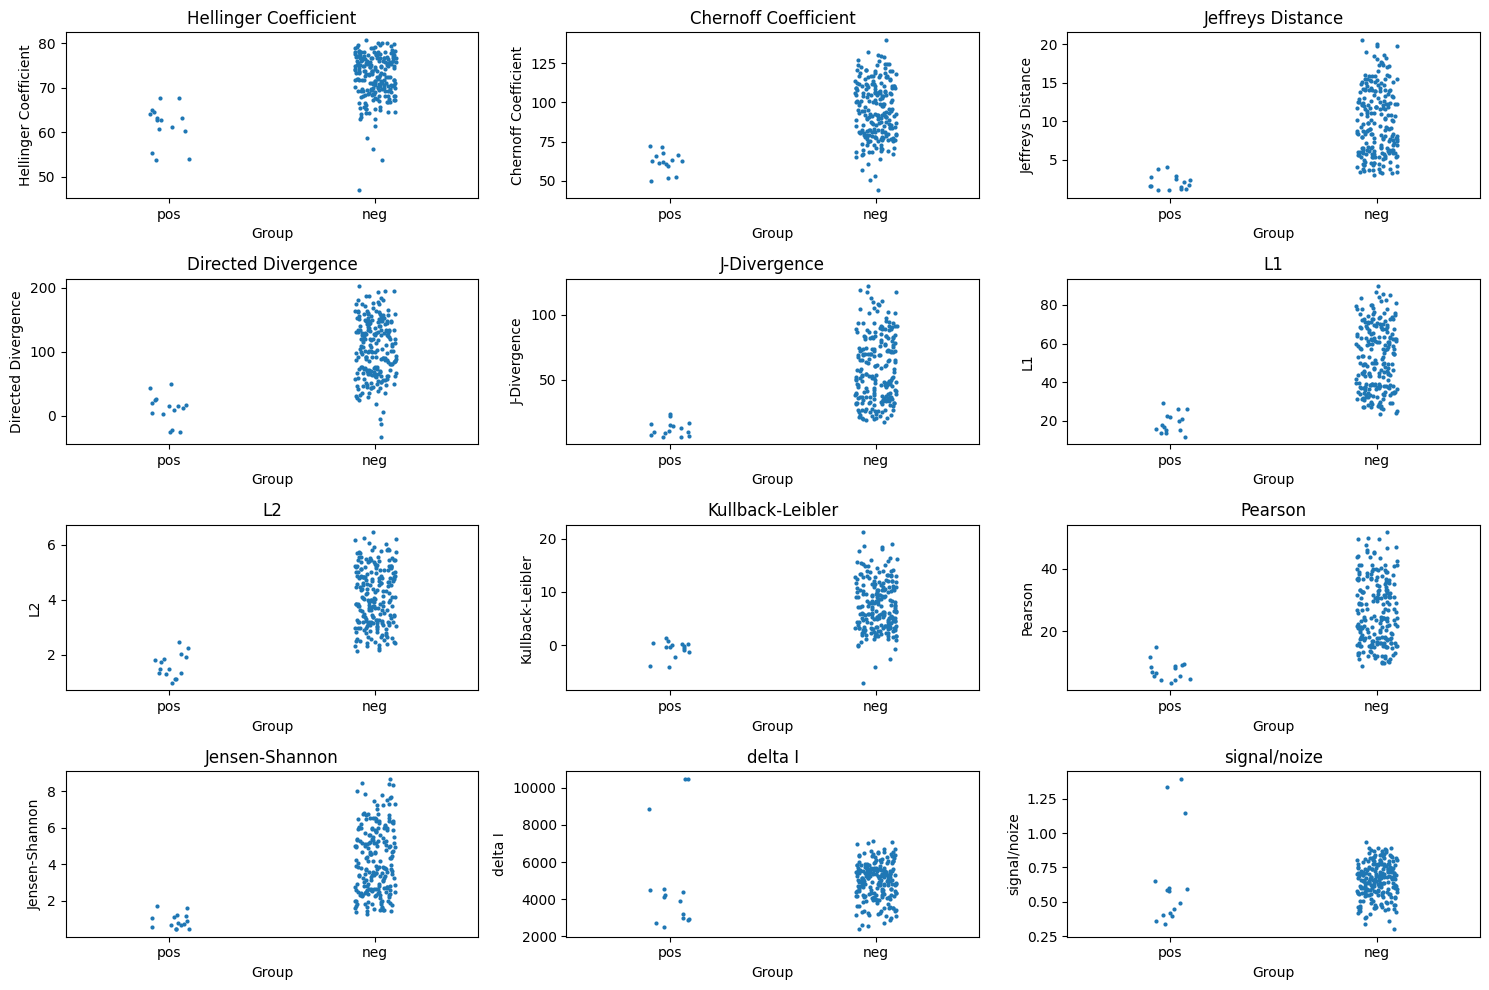

In [9]:
#swarm plot by features
df=create_dataframe(feature_pos, feature_neg)
plot_swarm(df)

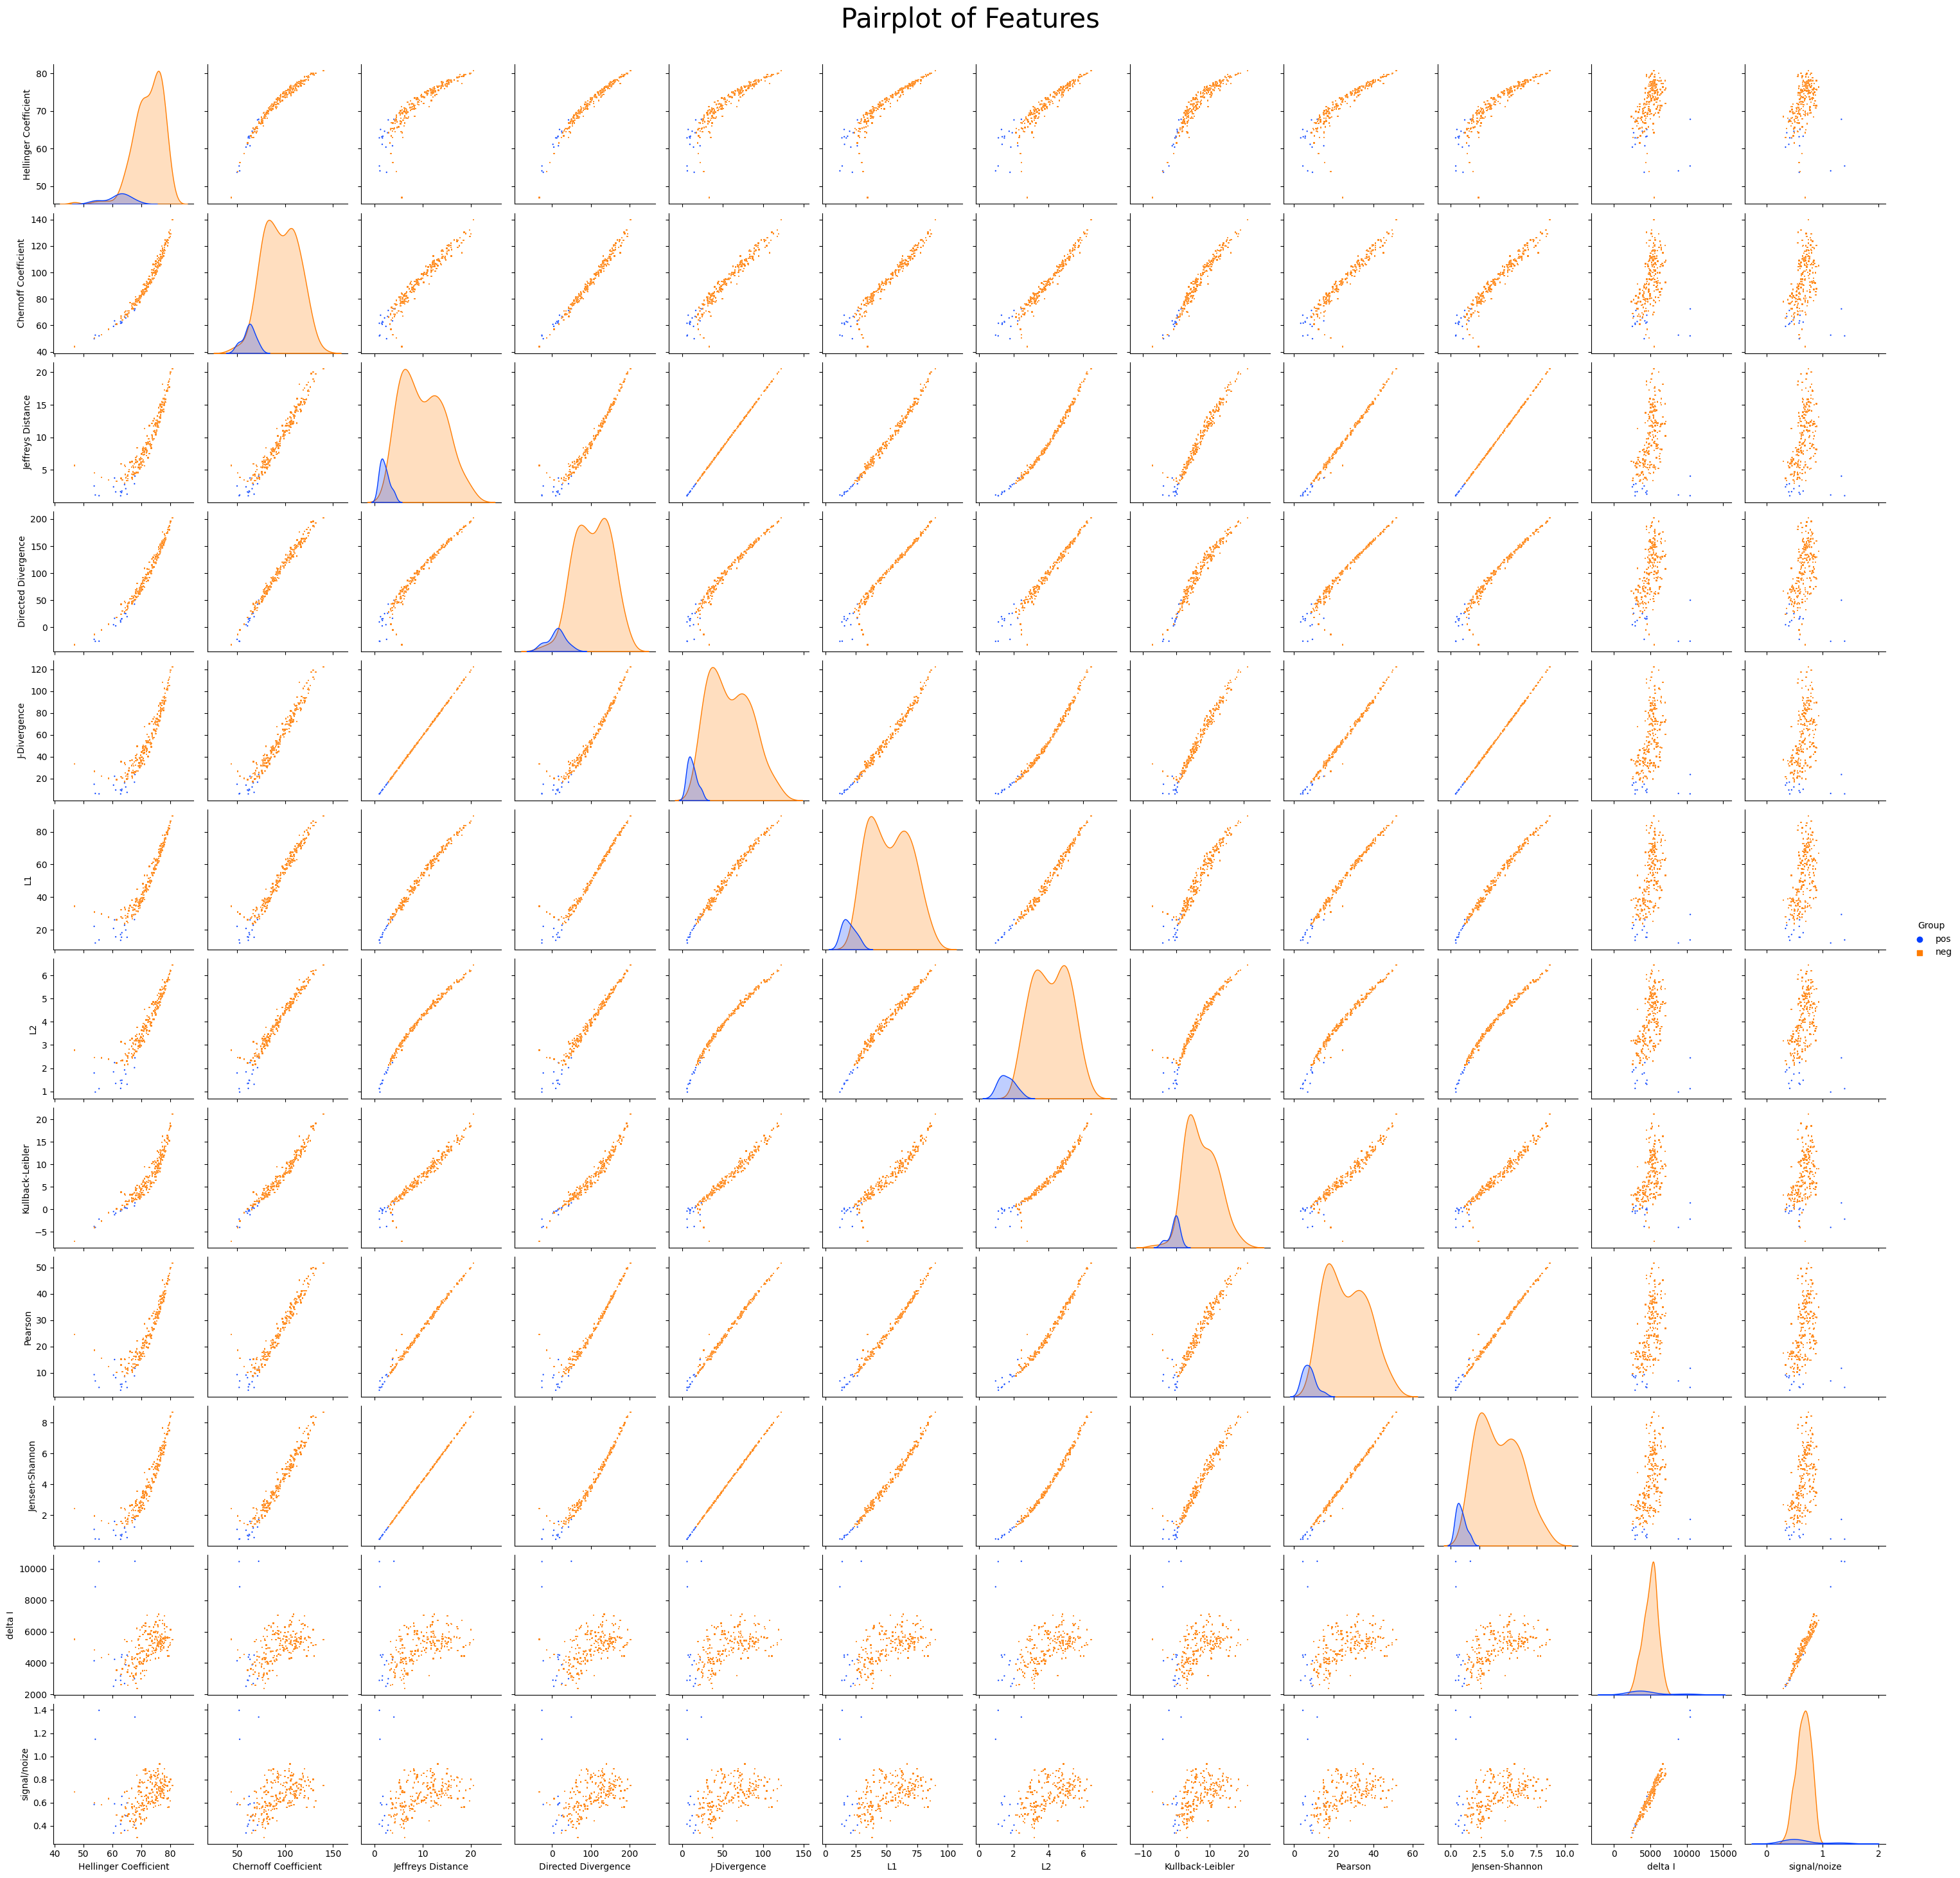

In [52]:
#pair plot by features
Make2Dplots(df,features)

In [10]:
tmp_p=[]
tmp_n=[]
for i in tensor_pos:
    tmp_p.append([i[0,0],i[1,1],i[2,2]])  #only diagonal componets
for i in tensor_neg:
    tmp_n.append([i[0,0],i[1,1],i[2,2]])
tensor_df_pos = pd.DataFrame(tmp_p, columns=['Tensor_xx', 'Tensor_yy', 'Tensor_zz'])
tensor_df_neg = pd.DataFrame(tmp_n, columns=['Tensor_xx', 'Tensor_yy', 'Tensor_zz'])
tensor_df = pd.concat([tensor_df_pos, tensor_df_neg], ignore_index=True)
df2 = pd.concat([df, tensor_df], axis=1)
df2["experiment"]= exp_li
df2["CT"]= dir_li
df2["region"]=name_li
df2

,Group,Hellinger Coefficient,Chernoff Coefficient,Jeffreys Distance,Directed Divergence,J-Divergence,L1,L2,Kullback-Leibler,Pearson,Jensen-Shannon,delta I,signal/noize,Tensor_xx,Tensor_yy,Tensor_zz,experiment,CT,region
0,pos,60.408391,59.247325,2.397236,4.993903,14.022648,20.757355,1.840977,-0.516020,9.105888,1.027934,2521,0.339209,1315.204411,1330.073094,1309.457601,1st,cfos_CT0_01,Striatum
1,pos,64.219579,66.741328,2.742756,26.034078,16.041905,22.738026,1.923544,0.350148,8.526032,1.175972,2697,0.361383,1301.796654,1331.223031,1324.779134,1st,cfos_CT0_01,Striatum
2,pos,62.869974,61.590322,1.026292,10.031388,5.973552,13.502043,1.127385,-0.406799,3.362944,0.442054,2896,0.414959,1279.258734,1272.455899,1272.291848,1st,cfos_CT0_01,Striatum
3,pos,67.630947,71.264205,2.871879,42.936447,16.738652,26.185221,2.022258,0.740784,8.790767,1.235366,3003,0.407076,1324.105780,1317.633719,1308.359345,1st,cfos_CT0_01,Striatum
4,pos,61.149092,60.767872,1.623492,2.824062,9.556251,15.628529,1.342094,-0.873074,8.119828,0.692567,2911,0.398058,1289.771273,1287.322721,1276.793770,1st,cfos_CT0_01,Striatum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,neg,77.988498,120.673873,15.307927,158.581118,90.699598,73.484123,5.460345,13.831239,39.582617,6.486314,6420,0.788601,1326.621214,1401.119257,1332.332910,1st,cfos_CT0_01,Striatum
225,neg,75.749154,104.322428,11.641306,129.258610,68.788103,62.342642,4.584857,8.167748,31.078564,4.945862,6323,0.873101,1325.343126,1299.099115,1333.686952,1st,cfos_CT0_01,Striatum
226,neg,78.037335,120.292439,15.164967,159.587803,89.528977,74.811033,5.429265,12.886956,39.967200,6.445645,7012,0.892793,1323.372528,1354.909189,1347.050720,1st,cfos_CT0_01,Striatum
227,neg,76.030156,108.981674,12.449640,134.677129,73.731798,63.675726,4.810726,9.680018,32.508003,5.277376,7103,0.844690,1289.137668,1367.657523,1271.733207,1st,cfos_CT0_01,Striatum


C:\Users\matsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



******************************************************************
Model: Logistic Regression
Accuracy: 0.9642147117296223
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       272
           1       0.97      0.95      0.96       231

    accuracy                           0.96       503
   macro avg       0.97      0.96      0.96       503
weighted avg       0.96      0.96      0.96       503

F1 Score: 0.9641744746830025
Coefficients: [[-0.22432873 -0.09842392 -0.75610272 -1.72506358 -0.02870256  0.03574458
  -0.02996757]]
Intercept: [44.62714943]
                      importance
Tensor_yy               0.035745
Tensor_xx              -0.028703
Tensor_zz              -0.029968
J-Divergence           -0.098424
Chernoff Coefficient   -0.224329
L2                     -0.756103
signal/noize           -1.725064

******************************************************************
Model: Support Vector Machine (SVM)
Accuracy: 0.84493041749

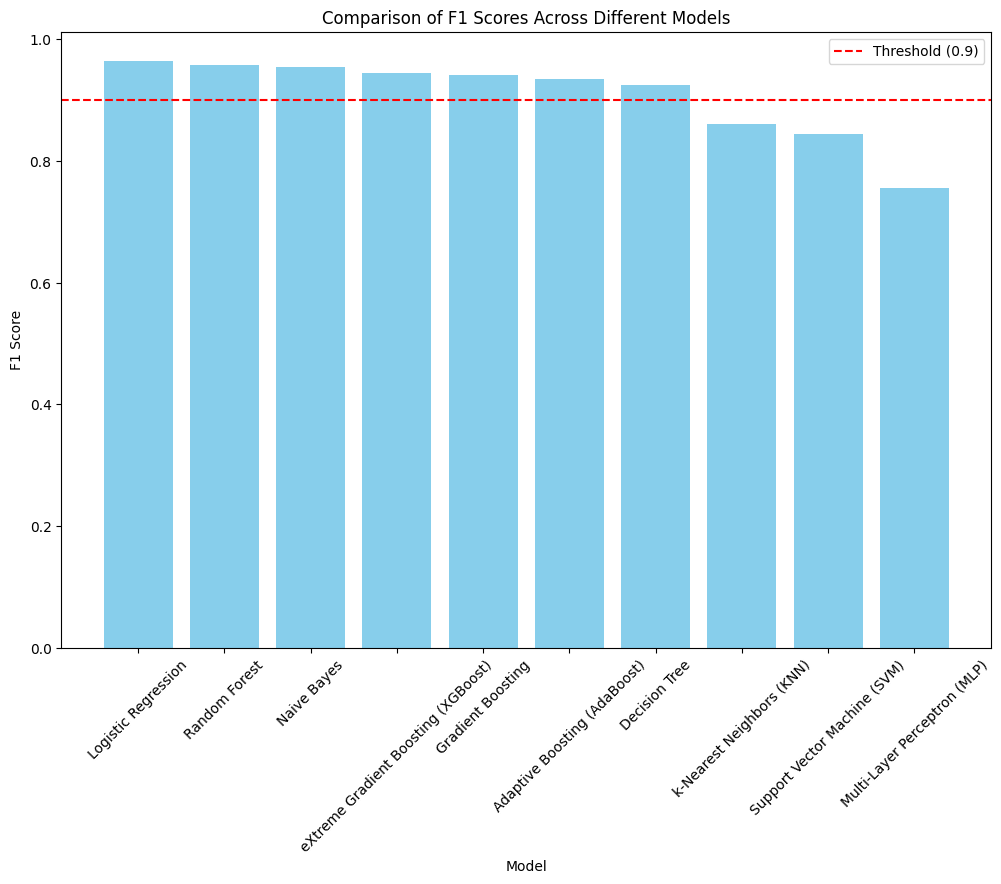

In [847]:
#evaluate models 
results =Machine_Learning(df2, features2, test_size=0.3, random_state=3)
# results =Machine_Learning(df2, best_features, test_size=0.5, random_state=42)

In [ ]:
#save best model using all features
model = "eXtreme Gradient Boosting (XGBoost)"
# "Logistic Regression": LogisticRegression(max_iter=1000),
# "Support Vector Machine (SVM)": SVC(),
# "k-Nearest Neighbors (KNN)": KNeighborsClassifier(),
# "Gradient Boosting": GradientBoostingClassifier(),
# "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
# "Decision Tree": DecisionTreeClassifier(),
# "Multi-Layer Perceptron (MLP)": MLPClassifier(max_iter=1000),
# "Naive Bayes": GaussianNB(),
# "eXtreme Gradient Boosting (XGBoost)": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
# "LightGBM": LGBMClassifier(),
# "Adaptive Boosting (AdaBoost)":
model_name = "xgboost_ratioI_fpr{}".format(fpr)
df_test_pred = Learn_save_best(df2, features2, model, model_name, test_size=0.3, random_state=42)
print(df_test_pred)
len(df_test_pred)

In [ ]:

# df2_pred.to_csv(dst + "/cfos_teachers/deconv_detection/test_results_edge2.csv")

In [ ]:
#F1 score by teacher regions
from sklearn.metrics import f1_score
region_names = ["SCN", "Striatum", "CA1", "SSpm23"]

pred = df_test_pred["predict"]

df2_pred = df2.iloc[df_test_pred.index.tolist()]
df2_pred["predict"] = pred

print(df2_pred)
for i, region in enumerate(region_names):
#     if i>0:
#         continue
    df_r = df2_pred[df2_pred["region"]==region]
    labels = df_r["Group"].tolist()
    labels2 = []
    for l in labels:
        if l=="pos":
            labels2.append(1)
        elif l=="neg":
            labels2.append(0)
#     print(labels2)
    f1 = f1_score(labels2, df_r["predict"])
    print("f1 score, {} {}".format(region, f1))